# Analysis of single-plex TMT experiment: compare edgeR to limma

## Comet/PAW pipeline


### Phil Wilmarth, OHSU PSR Core, April 2019

## Overview and objectives

Most ways that isobaric labeling data are analyzed hinder statistical testing and data visualization. This notebook will analyze data from (**Ref-1**) to demonstrate a two-condition (3 controls and 4 treatments) comparison done with 10-plex TMT reagents using the SPS MS3 method (**Ref-2**) on a Thermo Fusion instrument. The notebook will show how to:

- load in a complicated results table and extract the data
- normalize the data and check the result
- compare the two conditions using edgeR
- compare the two conditions using limma
- compare edgeR results to limma results

## Experiment background and PAW data processing

The KUR1502 data were mouse bone marrow cell cultures where the "media" samples are controls (one of the 4 did not label) and there are leukemia exosome-dosed cells (4 "exosome" samples). 10-plex TMT was used on a Thermo Fusion using the SPS MS3 method. The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) (**Ref-3**) is our in-house processing using the Comet search engine (**Ref-4**). The pipeline converts the RAW files into text files using MSConvert from the Proteowizard toolkit (**Ref-5**).

Data from the MS2 scans are extracted for the Comet searches and the reporter peak heights are extracted from the MS3 scans. The pipeline uses the target/decoy method to make score histograms and determine score filtering thresholds. Accurate mass is used to create conditional score histograms where target/decoy delta mass histograms are used to set the accurate mass windows. Basic parsimony principles are used for protein inference and 2 peptides per protein were required. An additional protein grouping step was used to combine nearly identical peptide sets (often these are housekeeping genes).

> **1.** Huan, J., Hornick, N.I., Goloviznina, N.A., Kamimae-Lanning, A.N., David, L.L., Wilmarth, P.A., Mori, T., Chevillet, J.R., Narla, A., Roberts Jr, C.T. and Loriaux, M.M., 2015. Coordinate regulation of residual bone marrow function by paracrine trafficking of AML exosomes. Leukemia, 29(12), p.2285.

> **2.** McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158.

> **3.** Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> **4.** Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

> **5.** Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918

## Differential expression (DE) testing

There are some hidden constraints in these experimental designs. The total amount of protein is usually fixed at the same value across all samples (an individual biological replicate). High abundance proteins are constrained by the total protein amount and do not have the same freedom for abundance differences that proteins that are smaller fractions of the total have. Higher abundance proteins must, by experimental design, have moderated differences in means and reduced variances. Lower abundance proteins have more freedom and will not be as constrained.

The constrained nature of these experimental designs (both genomics and proteomics) has implications in normalization algorithms. An increased expression in abundant proteins will "push" all other proteins down (their abundance total has to remain the same). Grand total normalization like we use above can be too simplistic. The differential expression testing package edgeR (**Ref-6**) includes a trimmed mean of M values (TMM) normalization step (**Ref-7**) designed for these types of samples.

> **6.** Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> **7.** Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

---

### Load libraries, data file, and edgeR data objects

In [57]:
# load libraries
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 

# read the grouped protein summary file
paw_raw <- read_tsv("grouped_protein_summary_TMT_8_sorted.txt", skip = 4,
                    n_max = 5427, guess_max = 5427)

Parsed with column specification:
cols(
  .default = col_number(),
  ProtGroup = col_double(),
  Counter = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character(),
  CountsTot = col_double(),
  UniqueTot = col_double(),
  UniqFrac = col_double(),
  Total_KUR1502 = col_double(),
  Unique_KUR1502 = col_double(),
  Corrected_KUR1502 = col_double(),
  PSMs_Used_KUR1502 = col_double()
)
See spec(...) for full column specifications.


In [58]:
# extract protein accession column and TMT data
# need to exclude any rows with an entry in "Filter" column
# there are also 4 unused channels (of 11-plex slots)
paw_tmt <- paw_raw %>% 
  filter(., is.na(Filter)) %>%
  select(Accession, starts_with("TotInt_")) %>%
  select(-contains("127N"), -contains("128N"), -contains("130N"), -contains("131C"))

# separate accessions from the data
accession <- paw_tmt$Accession
paw_tmt <- paw_tmt %>% select(-Accession)

# rename the columns and gather the conditions
colnames(paw_tmt) <- c("Media_2.1", "Exo_2.1", "Exo_2.2", "Media_2.2",
                      "Exo_3.1", "Exo_3.2", "Media_3.2")
paw_tmt <- paw_tmt %>% select(contains("Media"), contains("Exo"))

head(paw_tmt)
nrow(paw_tmt)

Media_2.1 Media_2.2 Media_3.2 Exo_2.1 Exo_2.2 Exo_3.1 Exo_3.2
1 3933357   4407161   3673067   3365868 2877318 4087298 4900769
2 5776706   7291692   5960994   6059613 4975721 7275906 8452274
3 1014940   1257965   1085345    960414  817656 1651860 1998265
4 6870884   8431112   6883385   5565945 4276295 7595261 8567091
5 5581931   7025343   6028481   5919861 4716778 7657665 8385431
6 5784291   7072911   5227963   5569973 4762455 6382760 6863332

[1] 4976

In [59]:
# load data into DGEList object
group <- c(rep("media", 3), rep("exosome", 4))
y <- DGEList(counts = paw_tmt, group = group, genes = accession)
y$samples

group   lib.size   norm.factors
Media_2.1 media   1027236544 1           
Media_2.2 media   1269260855 1           
Media_3.2 media    916023072 1           
Exo_2.1   exosome  751966489 1           
Exo_2.2   exosome  615347770 1           
Exo_3.1   exosome  829342908 1           
Exo_3.2   exosome  943200022 1

### Normalize the TMT data

EdgeR normalization is actually done in two steps. The first, called a library size adjustment, is like a sample loading normalization. This gets rid of the big differences between samples so that the TMM algorithm has better starting data. We need to compute the normalized intensities from the TMM factors.

Overall Factors (lib.size+TMM):
 Media_2.1 -> 0.856378
 Media_2.2 -> 0.686205
 Media_3.2 -> 0.966401
 Exo_2.1 -> 1.217162
 Exo_2.2 -> 1.475263
 Exo_3.1 -> 1.143810
 Exo_3.2 -> 1.005158


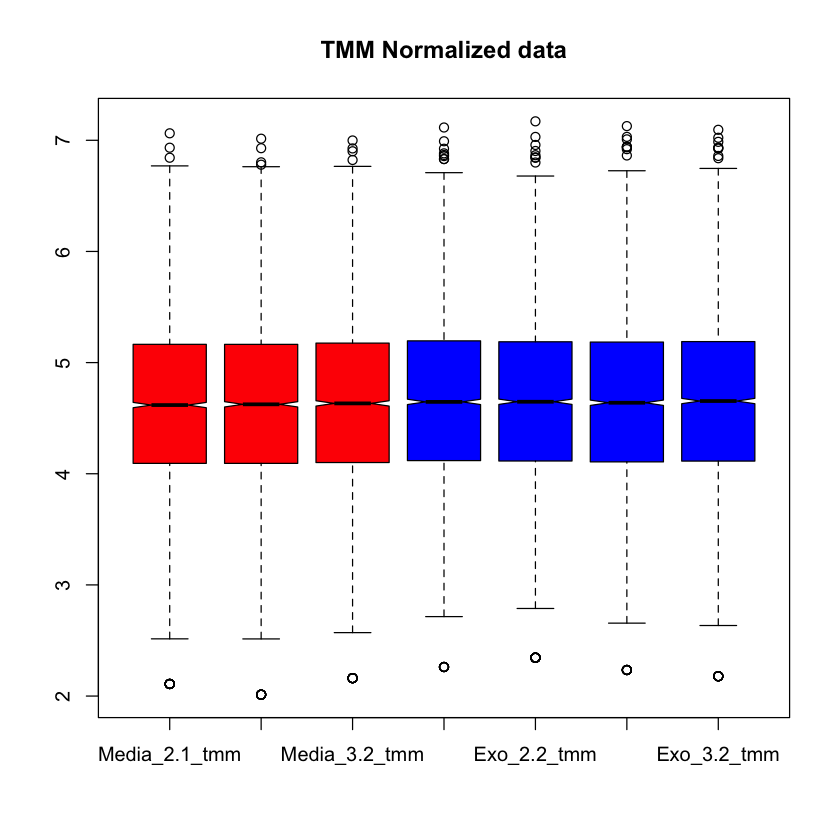

In [60]:
# run the TMM normalization
y <- calcNormFactors(y)

# set colors for plotting
color <- c(rep("red", 3), rep("blue", 4))

# function to compute the normalized intensities
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors
    cat("Overall Factors (lib.size+TMM):\n", sprintf("%-5s -> %f\n", 
                                                     colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# get the normalized data values
paw_tmt_tmm <- apply_tmm_factors(y, color)

### Compute dispersion for edgeR modeling

Design matrix not provided. Switch to the classic mode.


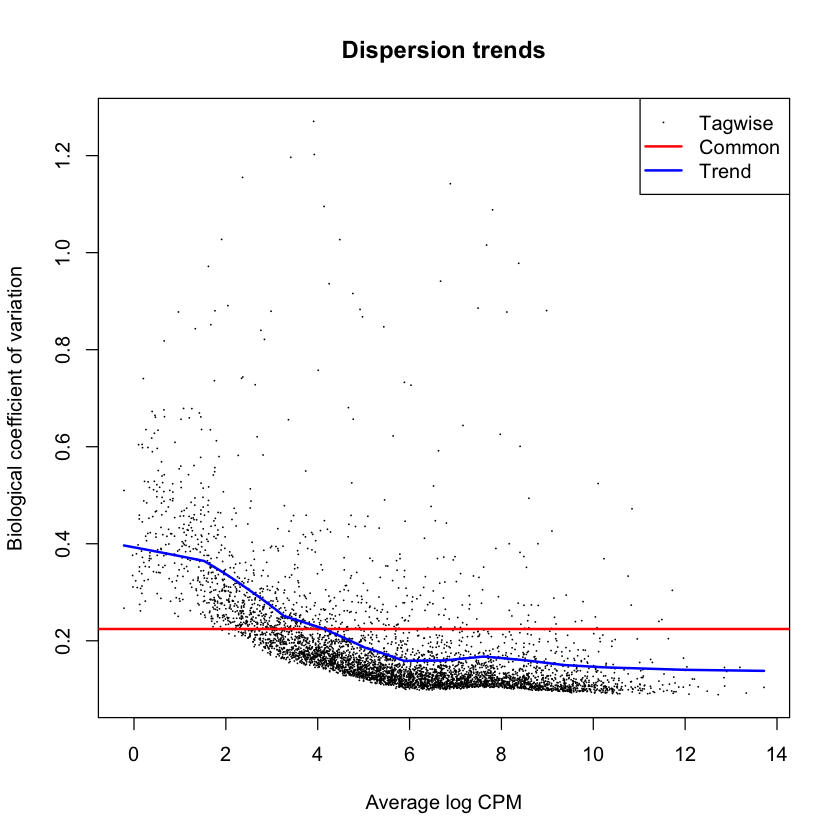

In [61]:
# we need to get dispersion estimates
y <- estimateDisp(y)
plotBCV(y, main = "Dispersion trends")

## Dispersion depends on the protein intensity

There are abundance-dependent dispersion effects in many measurement methods. Higher abundance signals have better signal-to-noise (or are the result of more averaging), so they can appear more precise than lower abundance signals. We see that the trended variance blue line increases as the protein intensity decreases. The statistical testing will use trended variances (estimated from multiple proteins) **as a function of** protein intensity, which spans several orders of magnitude. EdgeR puts the data on a common "counts per million" scale. The library size and TMM scaling factors essentially normalize the total signal per channel to 1.0. Multiplying by one million is done to convert to the CPM scale.

There are two important observations about the data and the blue line. The blue line is greater than the per protein variances for most proteins (the region with log CPM between 4 and 8 is a good example). This prevents proteins with small mean difference that might also have atypically low variance from throwing really small p-values. This is a nice consequence. 

There is also a flip side. Some of the proteins have variances that are greater than the blue line. If they have larger differences in means, the lower trended variance rather than their higher direct variances will result in small p-values. Real sample contaminant proteins (such as from surrounding tissue in dissections) can vary sample-to-sample, have high variance, and potentially be biased among conditions. These proteins might not have small p-values in traditional tests despite large differences in means if the variance was also very large.

### edgeR exact test

We will use the exact test in edgeR for this simple two-state comparison. You may wonder why we are using statistical testing built on a negative binomial distribution for counting experiments. The shortest answer is because it seems to work okay. The variance is modeled by two terms: one for Poisson numbers and an over-dispersion term. As counts get larger (several hundred or so), the Poisson term becomes small and the variance is handled by the over-dispersion term. The values of reporter ion peak heights, particularly when summed into protein totals, are large numbers. After we get the results from edgeR, we will compare them to limma with trended variance, which uses a normal data distribution.   

In [62]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))

    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("media", "exosome"))

# define variables for the columns in each condition
M <- 1:3
E <- 4:7

# make the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
med_exo <- collect_results(paw_tmt_tmm, tt, M, "med", E, "exo")

### Run test and reformat results

The `exactTest` function does the modeling for the pairwise comparison. More than one pair can be present in DGEList objects to improve the dispersion estimates. The `topTags` function does the multiple testing corrections and returns more concise summaries of the testing results. The `collect_results` function combines some of the normalized data and test results into a concise `med_exo` data frame.

### Check if testing looks okay

It is important to see if the modeling looks reasonable. Our general assumptions are that we have a large fraction of the proteins that are not differentially expressed. Those will have a uniform (flat) p-value distribution from 0.0 to 1.0. We also expect (hopefully) some true differential expression candidates. Those should have very small p-values and have a sharper distribution at low p-values. 

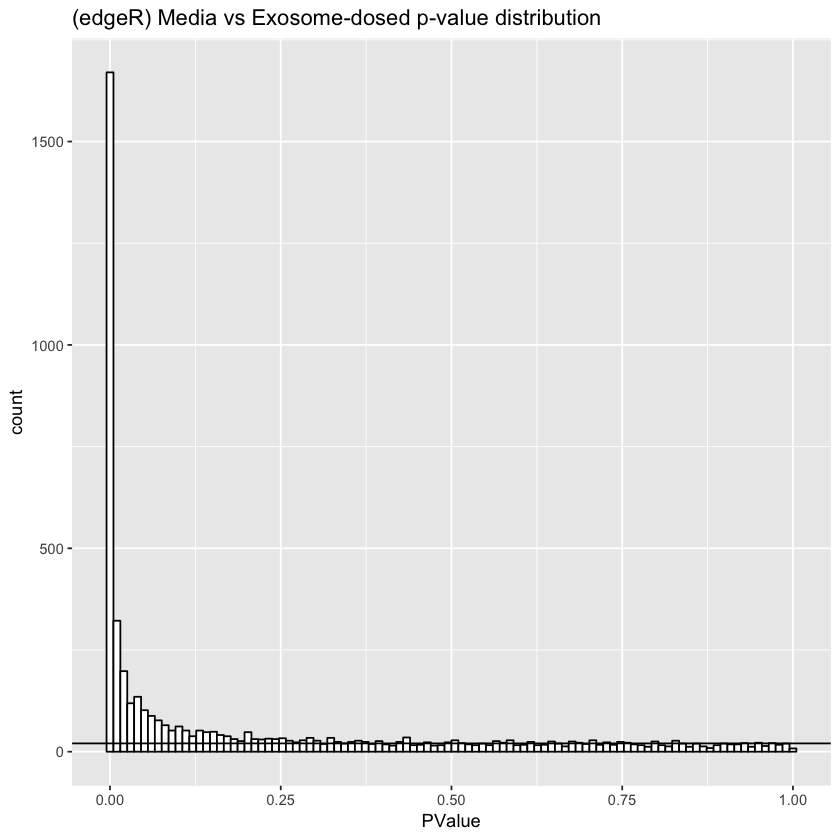

In [63]:
pvalue_plot <- function(results, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # title - plot title
    ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100])) +
        ggtitle(str_c(title, " p-value distribution"))
}

# check the p-value distrubution
pvalue_plot(med_exo, "(edgeR) Media vs Exosome-dosed")

### We have the expected distributions

We have the two distributions of p-values, so the testing seems reasonable. We can also see how the up-regulated protein number compares to the down-regulated number. We can use the `topTags` function to see which proteins have the smallest p-values.

In [64]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# see which proteins have the smallest p-values
topTags(et)$table

       exosome-media
Down            1236
NotSig          2487
Up              1253

genes                 logFC    logCPM    PValue        FDR          
4640 sp|Q3UHQ6|DOP2_MOUSE  9.500352  5.836843 1.552477e-187 7.725127e-184
3419 sp|P22777|PAI1_MOUSE  3.785082  3.953547  5.236968e-53  1.302958e-49
4939 sp|Q9QXV1|CBX8_MOUSE  7.129619  6.307572  3.877339e-51  6.060352e-48
450  sp|P54987|IRG1_MOUSE  2.509351 10.097597  4.871666e-51  6.060352e-48
4504 sp|Q9JM51|PTGES_MOUSE 2.278748  5.963784  2.837318e-48  2.823699e-45
4148 sp|P04918|SAA3_MOUSE  3.385478  3.633576  9.952807e-48  8.254195e-45
3118 sp|P33766|FPR1_MOUSE  2.829381  5.537600  1.030196e-46  7.323219e-44
530  sp|Q9R0P3|ESTD_MOUSE  1.616199 10.016199  1.798983e-44  1.118967e-41
4404 sp|Q91XA2|GOLM1_MOUSE 4.487636  5.889516  7.891854e-44  4.363319e-41
1252 sp|P35173|CYT3_MOUSE  2.705802  8.965056  1.363845e-42  6.786495e-40

### We can categorize candidates by ranges of adjusted p-values
In many discovery experiments, a Benjamini-Hochberg adjusted p-value (FDR) cutoff of 0.05 (5%) might be pretty strict. We use a 10% cutoff to distinguish DE from non-DE candidates. We define three cuts on the FDR: 10% to 5% are "low" significance, 5% to 1% are medium significance, and less than 1% are more "highly" significant. Cut values can be adjusted depending on the experimental situation.

We can look at expression ratio distributions as a function of candidate category. If variance is not too variable protein-to-protein, then we would expect larger mean differences to be associated with lower FDR values. Faceted plotting in ggplot2 is a nice method for showing such things.

candidate n   
1 high      1580
2 med        534
3 low        375
4 no        2487

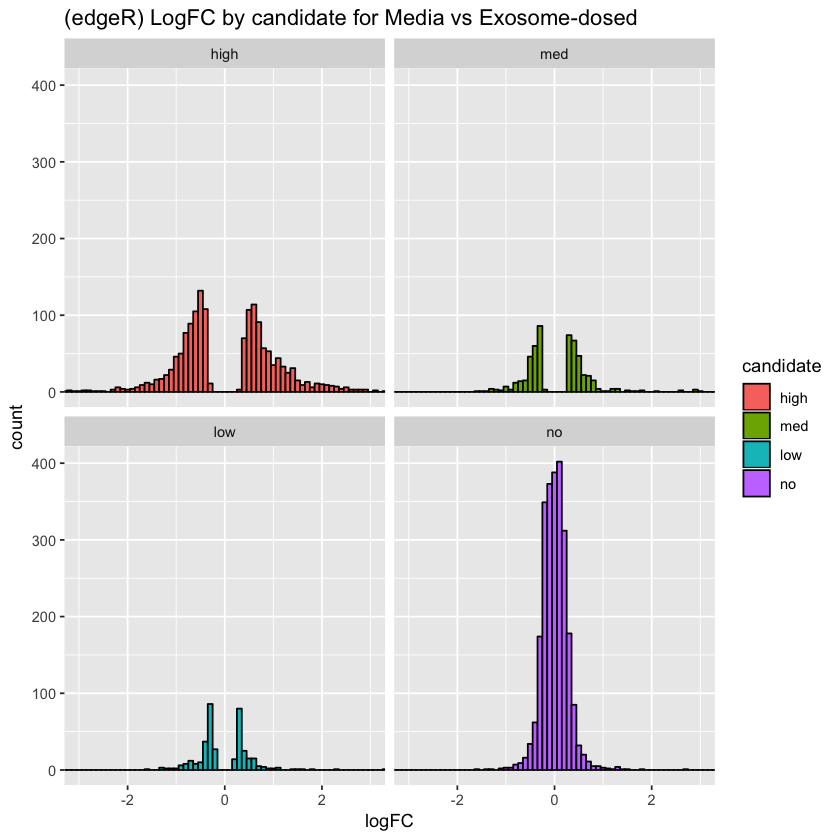

In [65]:
# see how many candidates are in each category
med_exo %>% count(candidate)

log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# can look at log2FC distributions as a check
log2FC_plots(med_exo, 3, "(edgeR) LogFC by candidate for Media vs Exosome-dosed")

### Visualize the edgeR DE candidates

- MA plots
- scatter plots
- volcano plot

We need some transformed axes for MA plots and for volcano plots. We will make a function for that and also some functions for the plotting. [MA plots](https://en.wikipedia.org/wiki/MA_plot) first. The dotted lines indicate 2-fold changes.

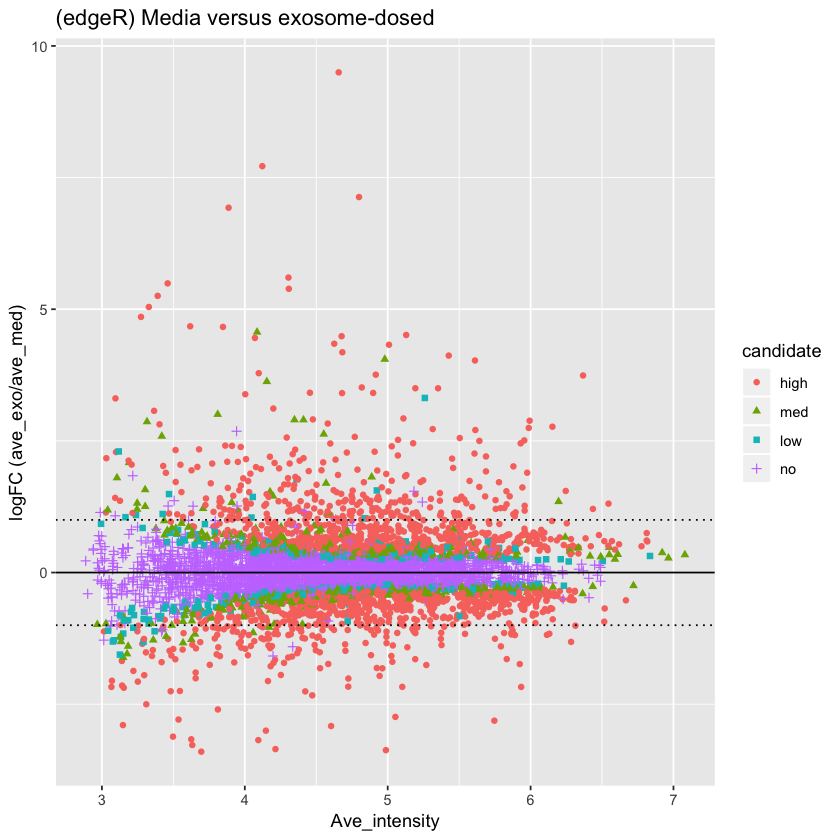

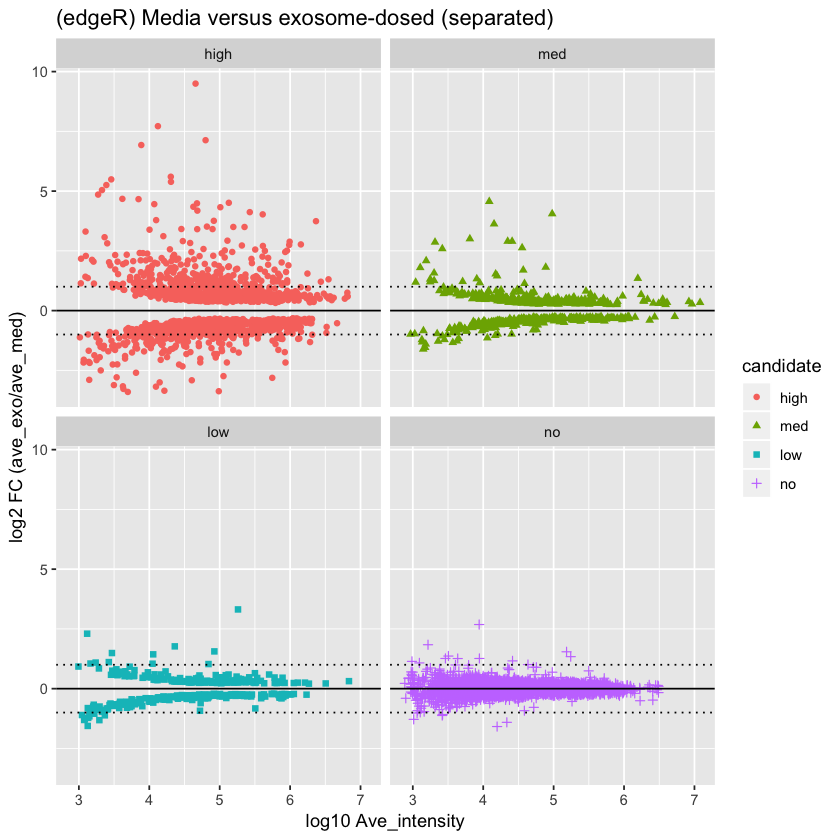

In [66]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    df # return the frame
}

MA_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    if (make_facet == TRUE) {
        ma_facet <- ggplot(temp, aes(x = A, y = M)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
            scale_x_continuous("log10 Ave_intensity") +
            ma_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)"))
    }

    # make the plots visible
    print(ma)
    if (make_facet == TRUE) {
        print(ma_facet)
    }
}    

# MA plots of DE candidates
MA_plots(med_exo, "ave_med", "ave_exo", "(edgeR) Media versus exosome-dosed")

### Scatter plots

The solid diagonal line is 1:1, the dotted lines are 2-fold changes. The axes are in log scale.

**NOTE:** We will skip these to shorten the notebook.

In [67]:
scatter_plots <- function(results, x, y, title, make_facet = TRUE) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # make_facet - flag to plot facet views
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    if (make_facet == TRUE) {
        scatter_facet <- ggplot(results, aes_string(x, y)) +
            geom_point(aes(color = candidate, shape = candidate)) +
            scatter_lines +
            facet_wrap(~ candidate) +
            ggtitle(str_c(title, " (separated)")) 
    }

    # make the plots visible
    print(scatter)
    if (make_facet == TRUE) {
        print(scatter_facet)
    }
}

#scatter_plots(med_exo, "ave_med", "ave_exo", "(edgeR) Media versus exosome-dosed")

### Volcano plot

Volcano plots are another common way to visualize DE candidates.

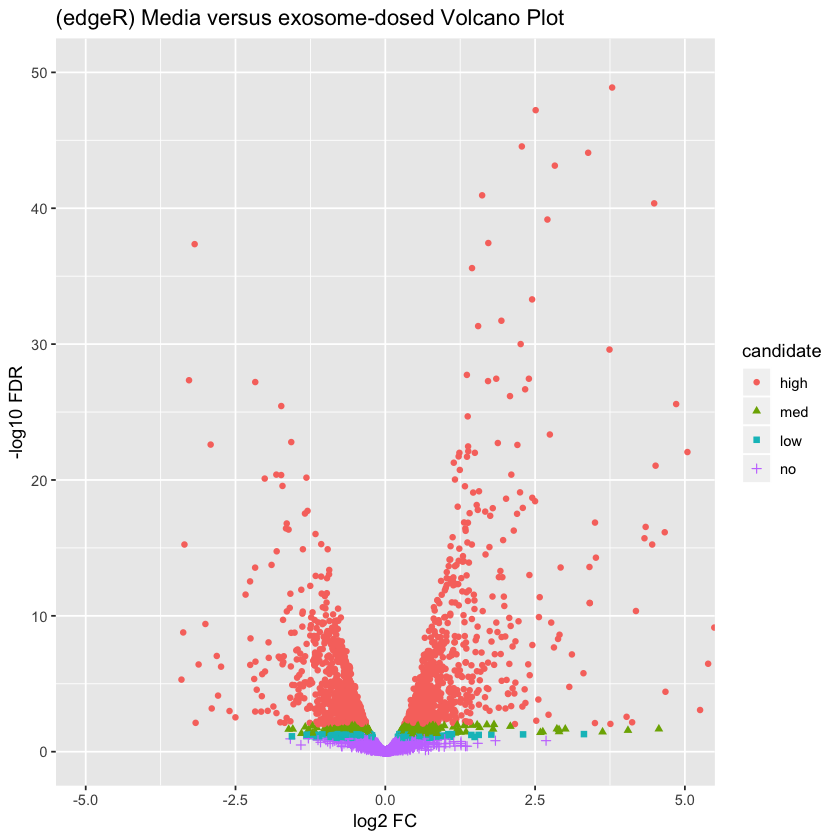

In [68]:
volcano_plot <- function(results, x, y, title, ymax) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # ymax - upper limit for y-axis
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        coord_cartesian(xlim = c(-5, 5), ylim = c(0, ymax)) + 
        ggtitle(str_c(title, " Volcano Plot"))
}

# finally, a volcano plot
volcano_plot(med_exo, "ave_med", "ave_exo", "(edgeR) Media versus exosome-dosed", 50)

### Plot the channel intensities for some of the top edgeR candidates by FDR

We can see how the intensities of the individual samples compare for the **top 10** up- and down-regulated edgeR candidate proteins.

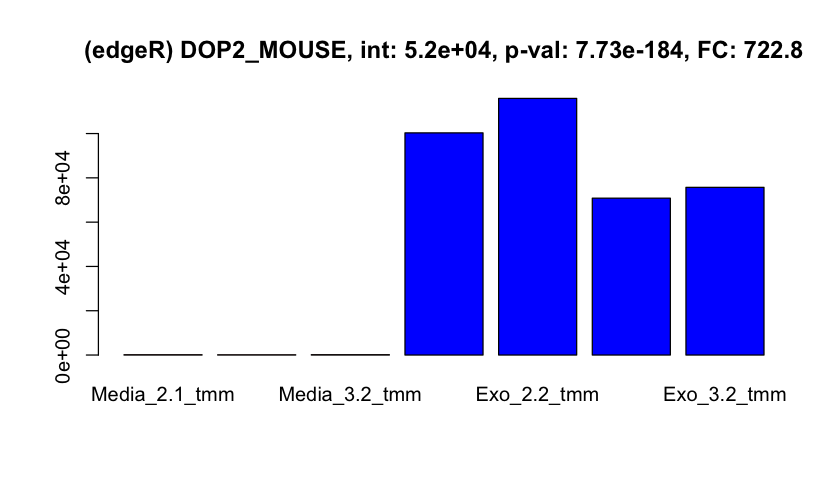

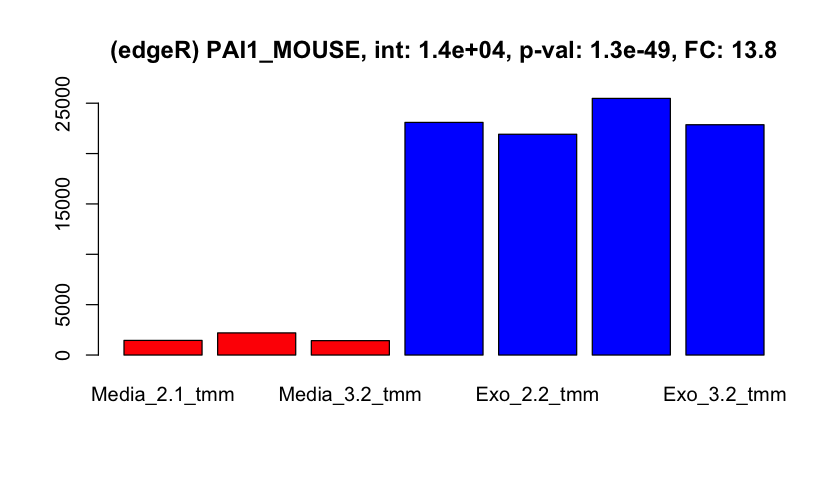

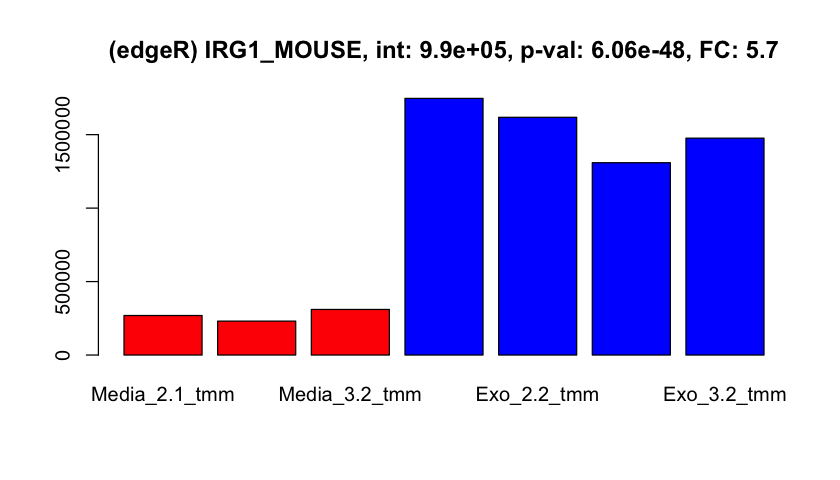

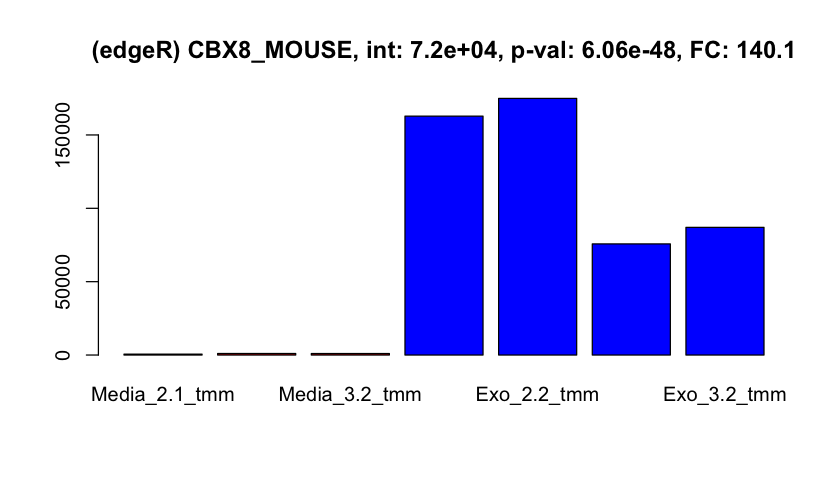

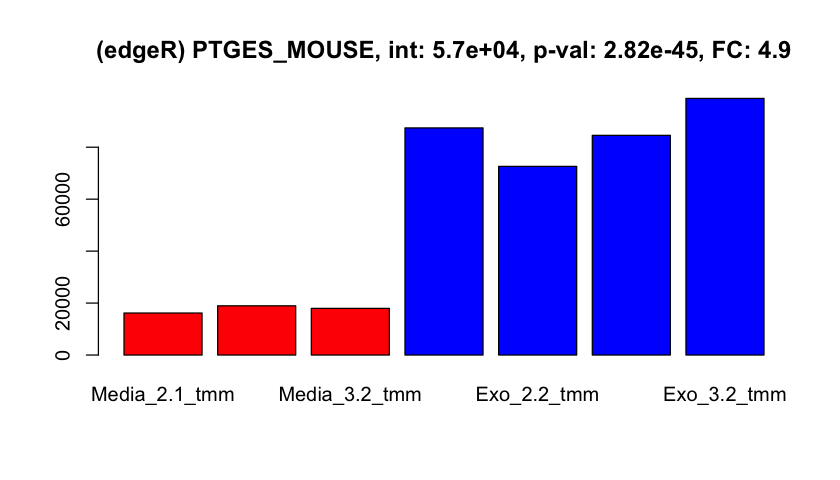

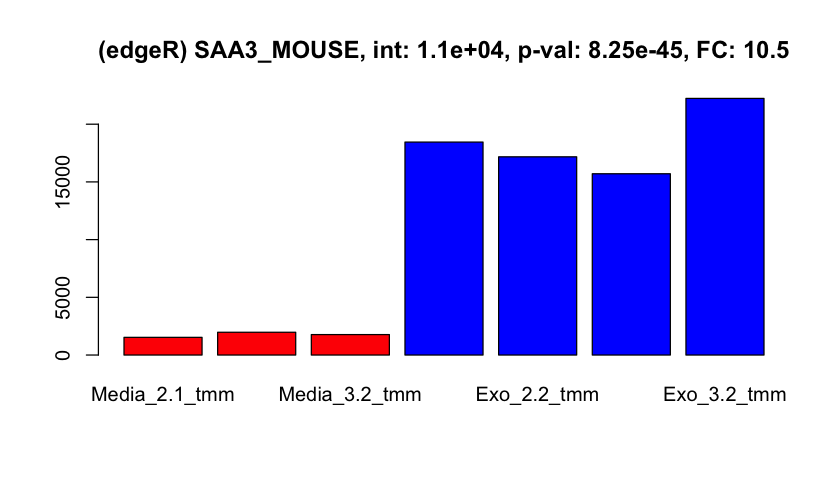

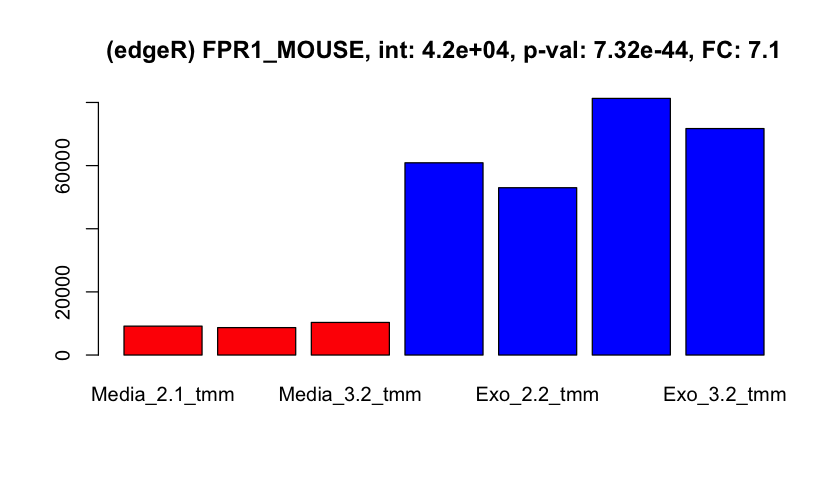

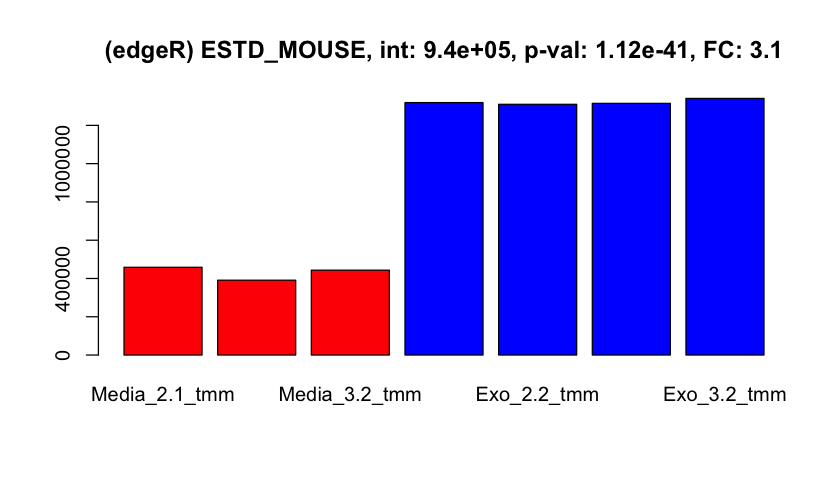

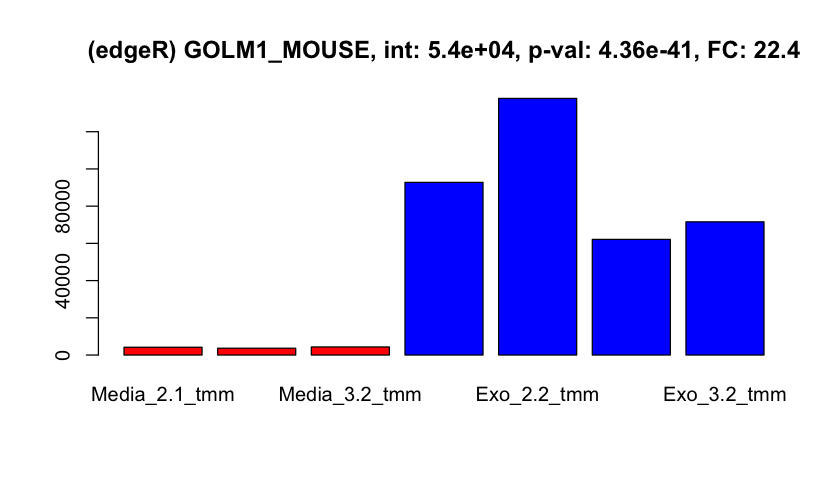

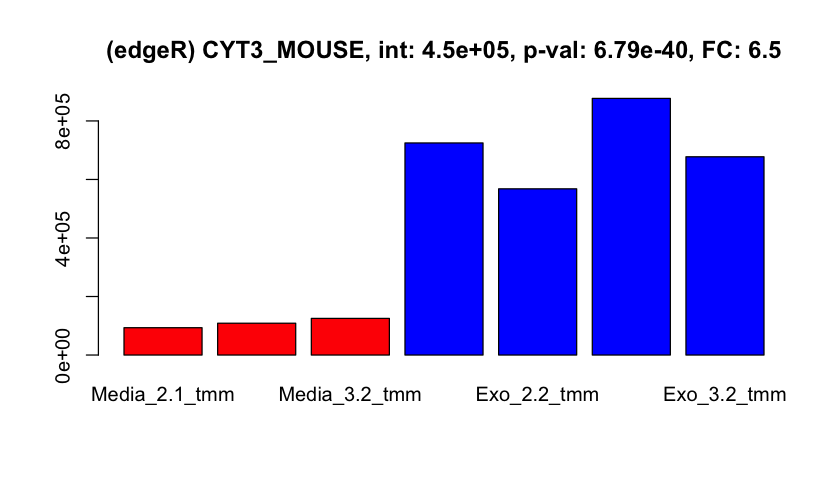

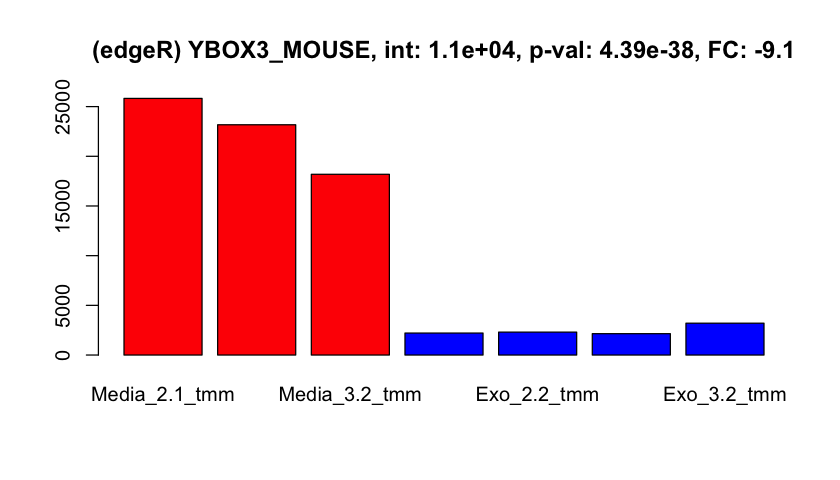

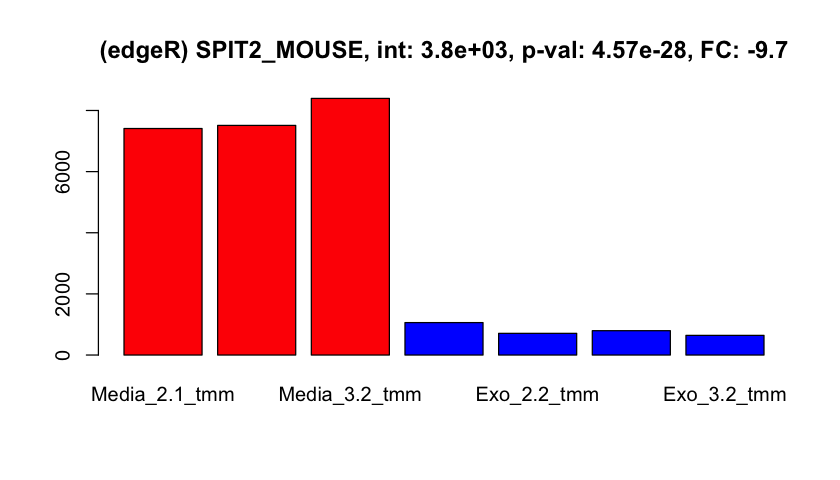

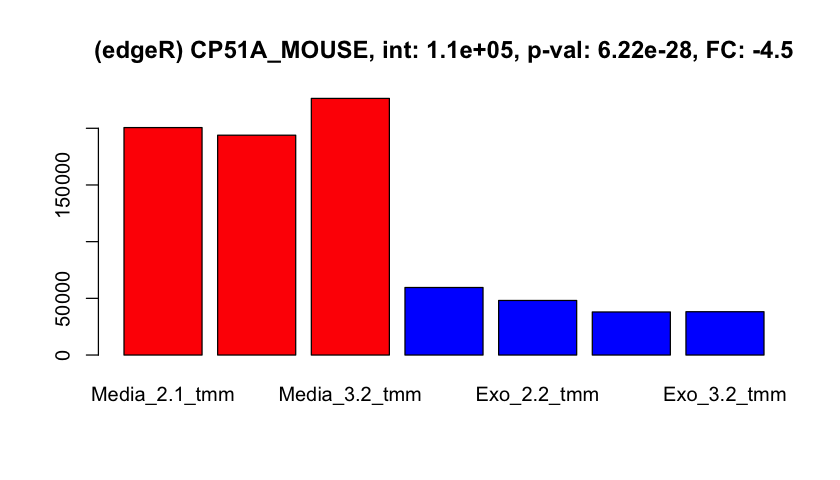

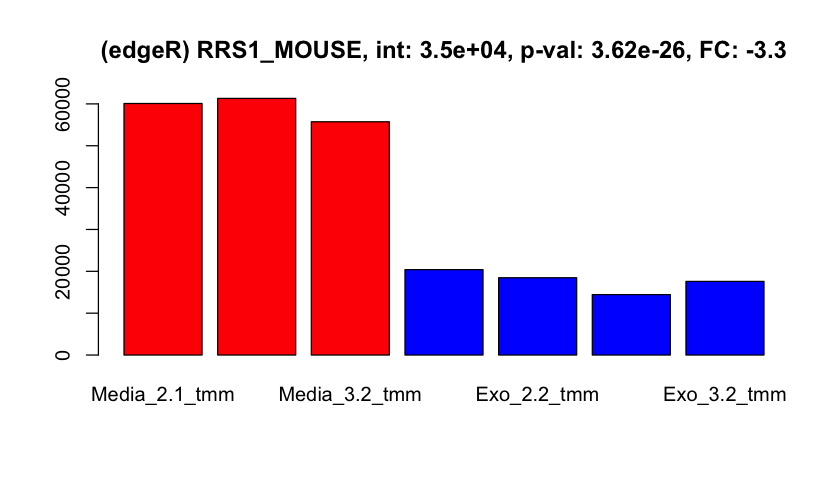

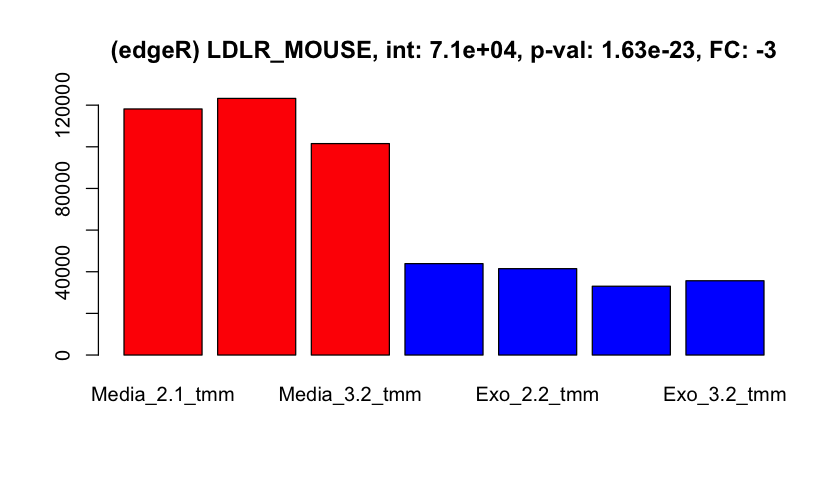

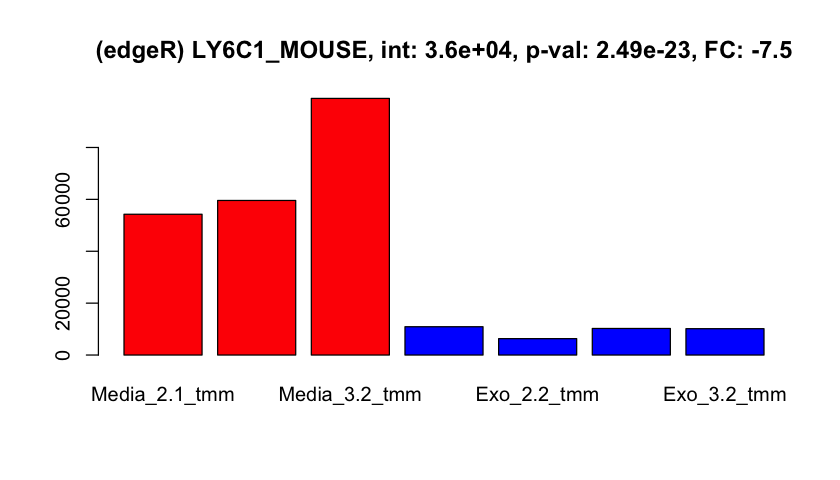

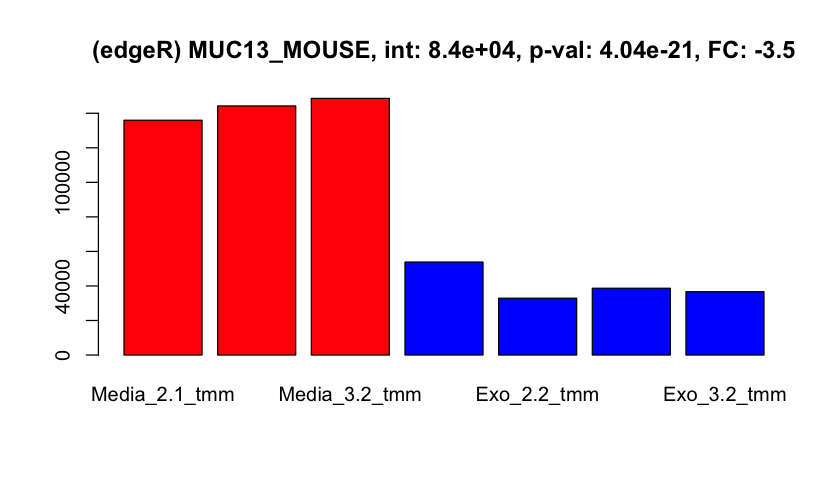

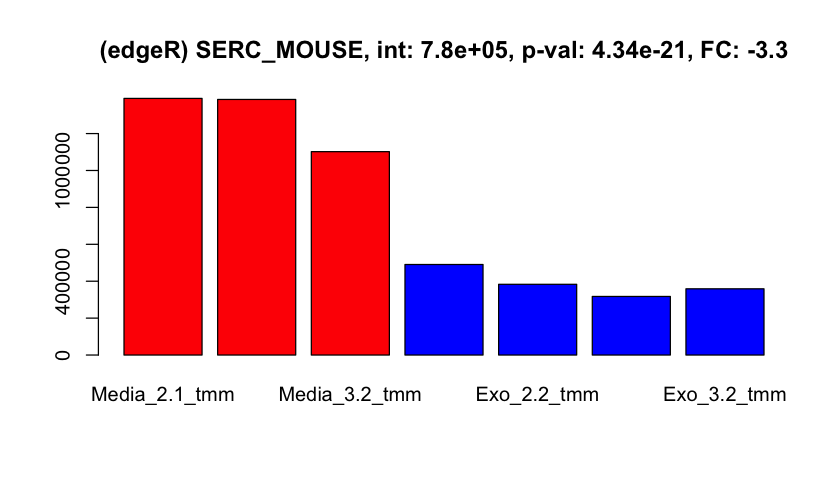

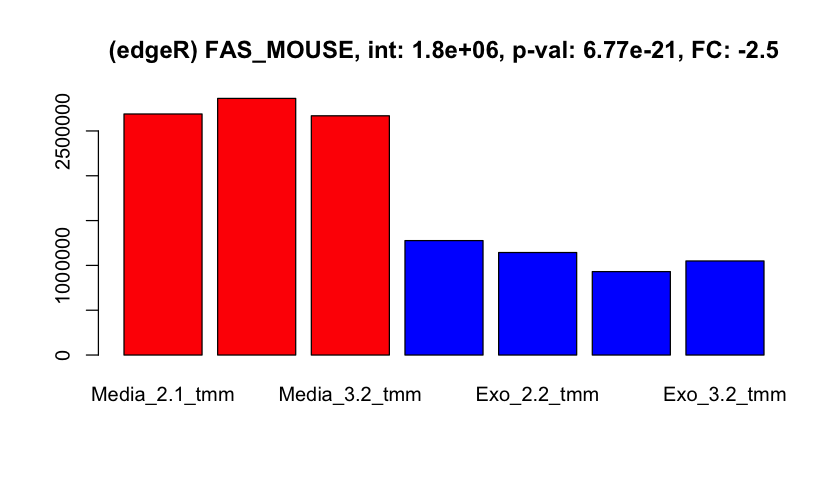

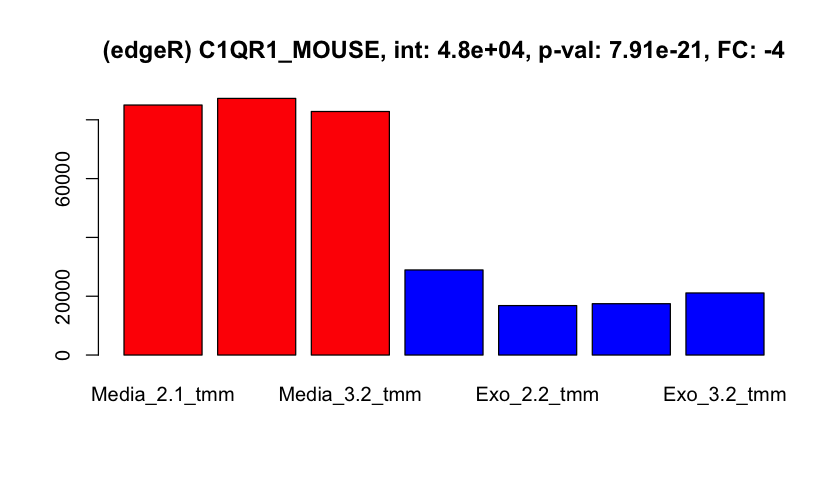

In [69]:
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags, prefix) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top up-regulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down-regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(prefix, get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

# plot the top 10 up and 10 down proteins
set_plot_dimensions(7, 4)
plot_top_tags(med_exo, 3, 4, 10, "(edgeR) ")
set_plot_dimensions(7, 7)

### Summary of edgeR testing

EdgeR normalizations and testing seemed reasonable for this data. 

- larger fold changes associated with more significant candidates
- wider dispersion at lower intensities is incorporated into edgeR testing
  - need larger fold changes at lower intensities to get the same significance
- proteins with larger fold-changes have much more significant p-values
  - we have a lot of dynamic range in the p-values

# Do a pair-wise test using limma with trended variance

The linear models for microarray (limma) package is a gold standard for analysis of genomics data. The citation below is a good starting point for learning more. limma is basically a moderated t-test modeling. There is some overhead to setup for the linear modeling. We will start with the TMM normalized intensities. We have the choice to use native intensities or log2 transformed intensities.

> Ritchie, M.E., Phipson, B., Wu, D., Hu, Y., Law, C.W., Shi, W. and Smyth, G.K., 2015. limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic acids research, 43(7), pp.e47-e47.

## Make design matrix and contrast

In [70]:
# copy the data
limma_PAW <- paw_tmt_tmm
row.names(limma_PAW) <- accession # add accessions as row names

# set up the design matrix
group <- as.factor(c(rep("media", 3), rep("exosome", 4)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("media", "exosome")
design

# make the contrast
contrast <- makeContrasts(exosome-media, levels = design)
contrast

media exosome
1 1     0      
2 1     0      
3 1     0      
4 0     1      
5 0     1      
6 0     1      
7 0     1

Contrasts
Levels    exosome - media
  media   -1             
  exosome  1

## Run linear models and see how many candidates

In [71]:
# do the linear model fitting
data_limma <- log2(limma_PAW[c(M, E)])
fit <- lmFit(data_limma, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(fit2, p.value = 0.10))
topTable(fit2)

       exosome - media
Down              1421
NotSig            2147
Up                1408

logFC    AveExpr  t        P.Value      adj.P.Val   
sp|Q3UHQ6|DOP2_MOUSE  9.482379 12.37523 41.17364 7.211393e-11 3.588389e-07
sp|P13597|ICAM1_MOUSE 1.717166 17.25261 24.57143 5.001213e-09 8.100823e-06
sp|P41216|ACSL1_MOUSE 1.446240 19.37427 24.10484 5.849525e-09 8.100823e-06
sp|Q9R0P3|ESTD_MOUSE  1.619470 19.63943 23.79037 6.511916e-09 8.100823e-06
sp|P22777|PAI1_MOUSE  3.813278 12.87382 20.66183 2.055084e-08 1.606341e-05
sp|Q9QXV1|CBX8_MOUSE  7.077953 13.80334 20.59910 2.106542e-08 1.606341e-05
sp|Q923D2|BLVRB_MOUSE 1.237322 17.55322 20.38756 2.290972e-08 1.606341e-05
sp|P54987|IRG1_MOUSE  2.511562 19.46750 20.01384 2.662671e-08 1.606341e-05
sp|Q8CEC6|PPWD1_MOUSE 1.362073 16.15328 19.64198 3.100754e-08 1.606341e-05
sp|Q9JM51|PTGES_MOUSE 2.273242 15.40667 19.54477 3.228178e-08 1.606341e-05
                      B        
sp|Q3UHQ6|DOP2_MOUSE  14.517752
sp|P13597|ICAM1_MOUSE 11.395159
sp|P41216|ACSL1_MOUSE 11.260453
sp|Q9R0P3|ESTD_MOUSE  11.167552
sp|P22777|PAI1_MOUSE  10.140185
sp|Q9QXV1|CBX8_MOUSE  10.117472
sp|Q923D2|BLVRB_MOUSE 10.040213
sp|P54987|IRG1_MOUSE   9.901129
sp|Q8CEC6|PPWD1_MOUSE  9.759362
sp|Q9JM51|PTGES_MOUSE  9.721735

## Save the results in `limma_PAW` and check p-values

[1] "Candidate Counts:"


high  med  low   no 
1446  881  502 2147

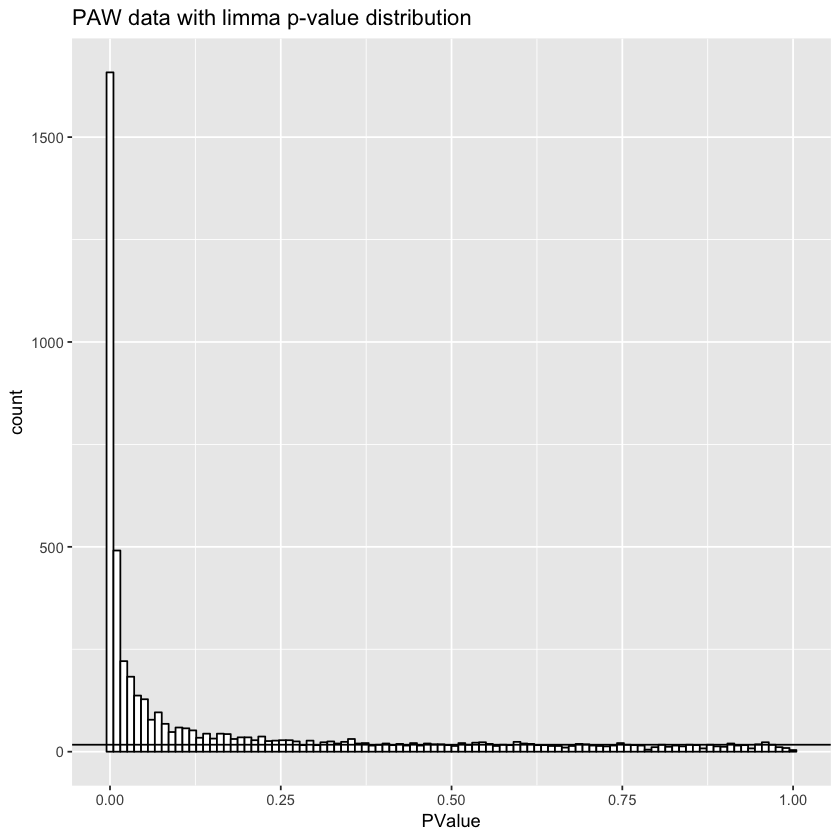

In [72]:
# add average ratio columns (non-logged ratios), fold-change column, and row names
limma_PAW$ave_med <- rowMeans(paw_tmt_tmm[M])
limma_PAW$ave_exo  <- rowMeans(paw_tmt_tmm[E])
limma_PAW$logFC <- log2(limma_PAW$ave_exo / limma_PAW$ave_med)
limma_PAW$FC <- ifelse(limma_PAW$ave_exo > limma_PAW$ave_med, 
                          (limma_PAW$ave_exo / limma_PAW$ave_med), 
                          (-1 * limma_PAW$ave_med / limma_PAW$ave_exo))
limma_PAW$Acc <- accession

# statisticl test results
limma_PAW$PValue <- tt_limma$P.Value
limma_PAW$FDR <- tt_limma$adj.P.Val

# add a DE candidate status column
limma_PAW$candidate <- cut(limma_PAW$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))

# count candidates
print("Candidate Counts:")
summary(limma_PAW$candidate)

# what does the test p-value distribution look like?
pvalue_plot(limma_PAW, "PAW data with limma")

## Candidate numbers and p-value distribution look okay

The total up and down candidate numbers are around 1400, a little larger than we had with edgeR. The number of candidates in the different FDR classes is similar; we have the most candidates in the "high" category. The p-value distribution is qualitatively quite similar. These bird's eye views seem reasonable.

limma is typically used on log2 transformed data. The non-transformed intensities can also be used, although some columns iin the results table (logFC) end up a bit nonsensical. Notebooks make it easy to change these options and run all of the downstream cells to see what the effects are. I did that and tabulated candidate numbers for the table below.

|Candidate Category|Log2 Intensity|Intensity|
|------------------|--------------|----------------|
|High < 0.01|1446|1279|
|0.05 > Med > 0.01|881|972|
|0.10 > Low > 0.05|502|487|
|Non-candidate > 0.10|2147|2238|

We get a  more candidates after taking the logs, so we will use log2 intensities for the rest of the notebook below.

We can look at the more detailed plots (MA plots, scatter plots, and volcano plot) to see what a deeper look into the DE candidates can tell us. We will repeat the edgeR DE plots from above for comparison.

## log2FC plots

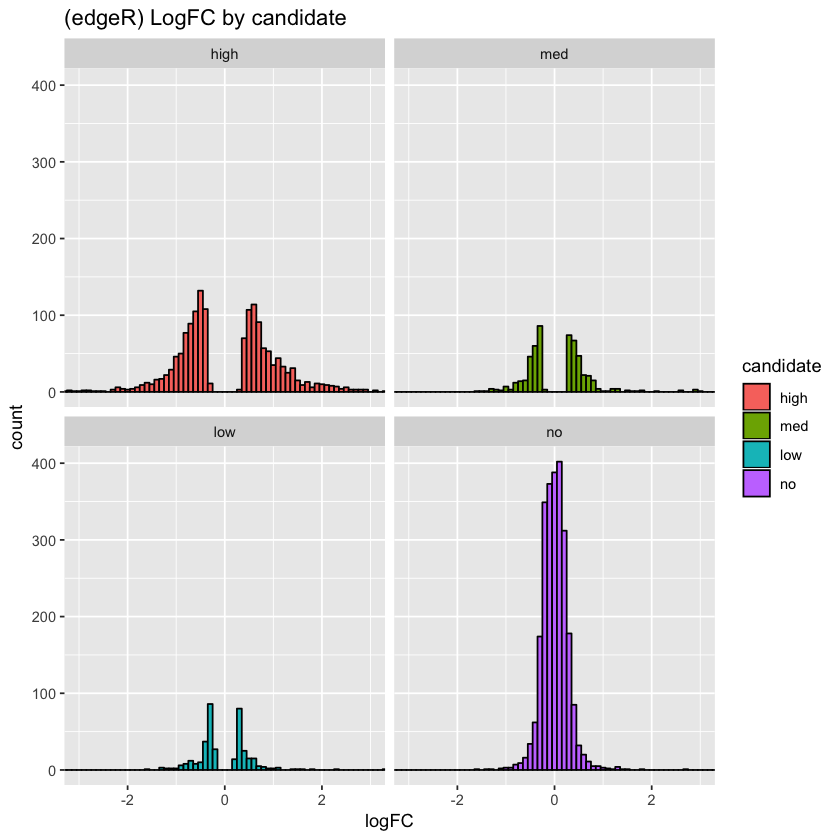

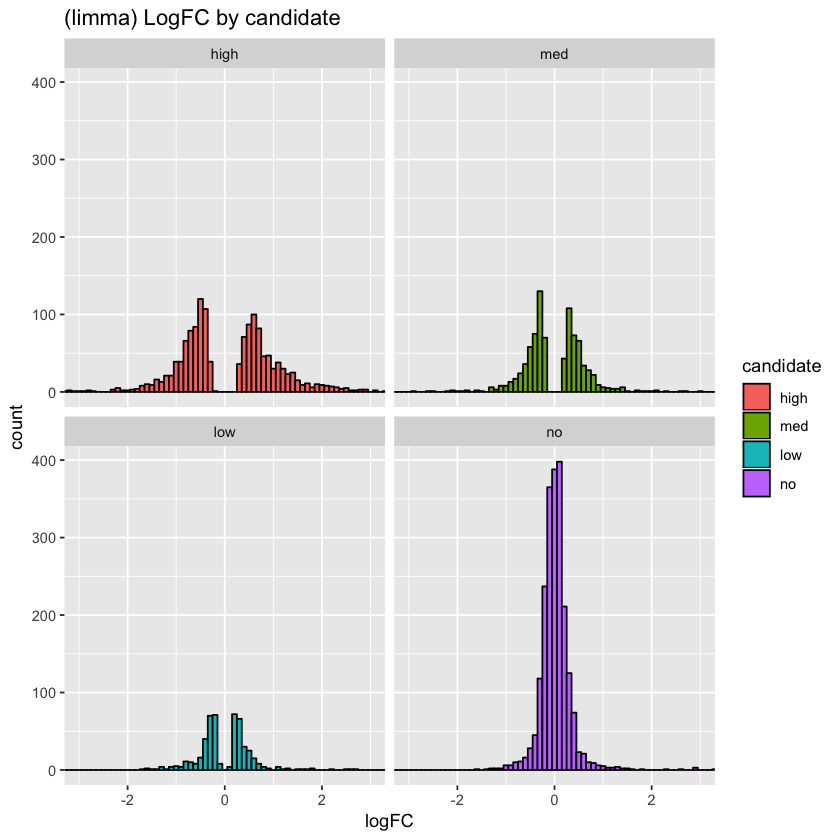

In [73]:
# can look at log2FC distributions as a check
log2FC_plots(med_exo, 3, "(edgeR) LogFC by candidate")
log2FC_plots(limma_PAW, 3, "(limma) LogFC by candidate")

### There is more similarity between edgeR and limma than we had for the t-test

We have some tendancy for more of the candidates to end up in the "high" category for edgeR than for limma where the medium category is relatively larger.

## MA plots

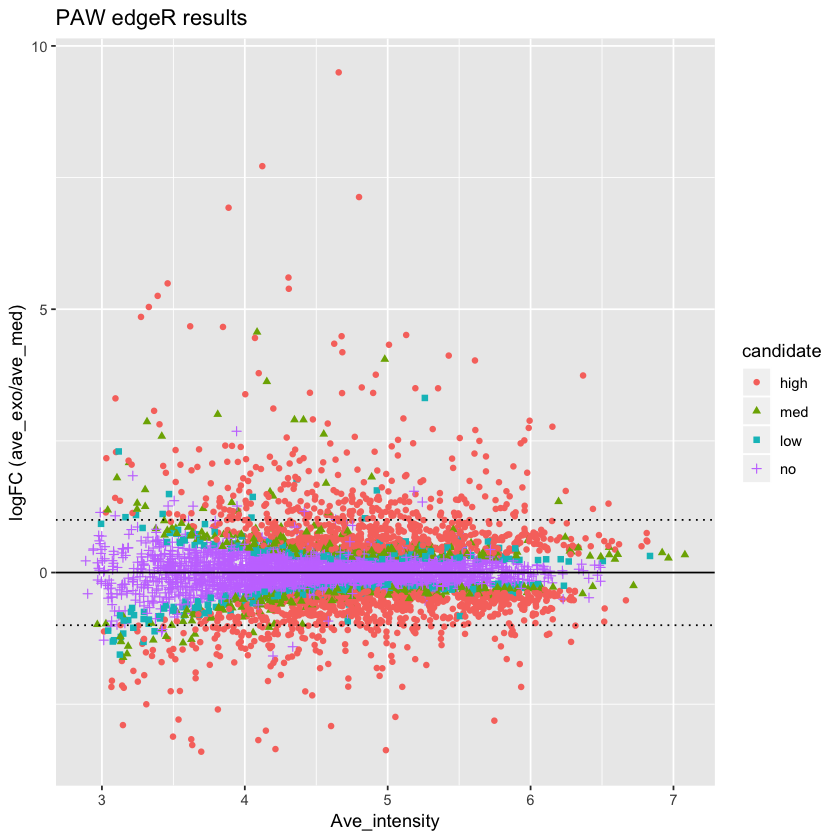

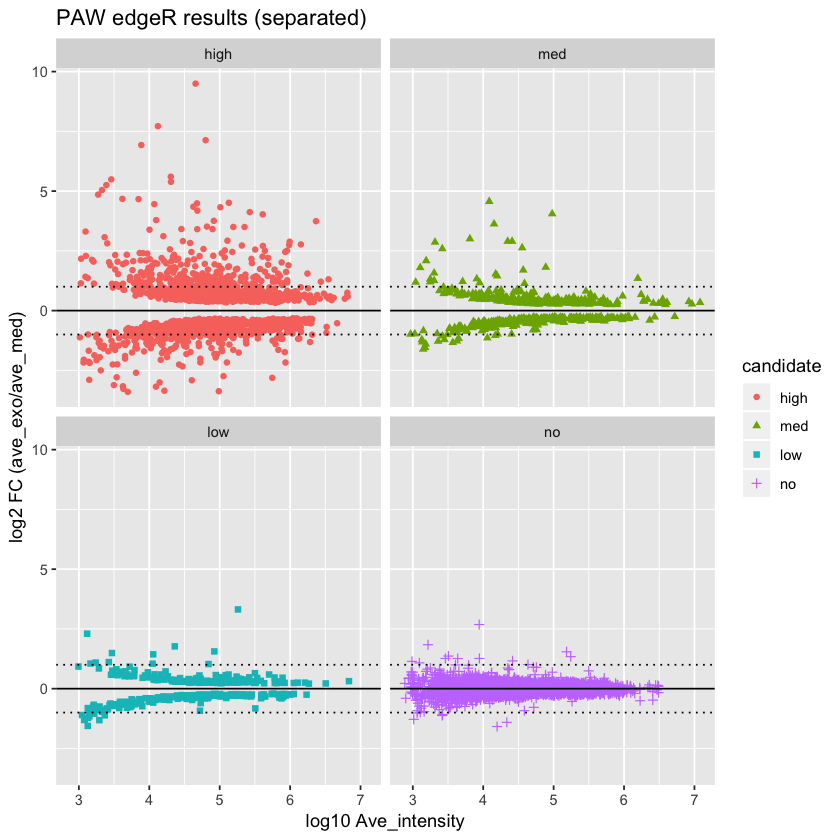

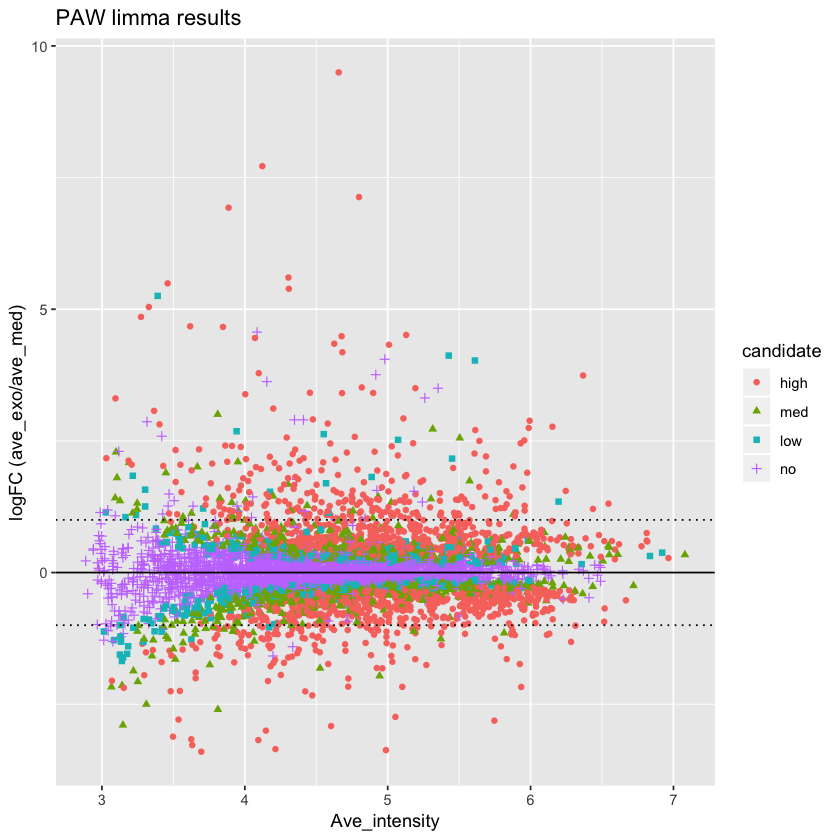

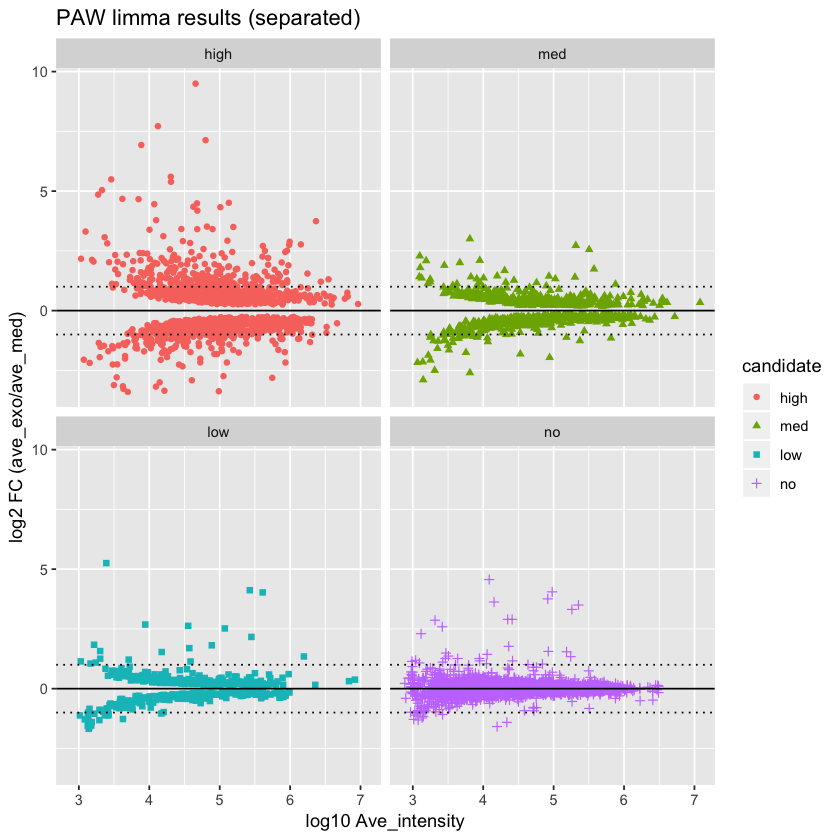

In [74]:
MA_plots(med_exo, "ave_med", "ave_exo", "PAW edgeR results")
MA_plots(limma_PAW, "ave_med", "ave_exo", "PAW limma results")

### Test results are pretty similar in appearance

limma results are more similar in appearance to edgeR than we had with the basic t-test. Proteins with very small fold-changes are excluded in both packages. We still have some large fold-change proteins that are not significant in limmma that ended up significant (at a 10% FDR cutoff) in edgeR. 

In [75]:
#scatter_plots(med_exo, "ave_med", "ave_exo", "PAW edgeR results")
#scatter_plots(ttest_PAW, "ave_med", "ave_exo", "PAW t-test results")

## Volcano plots

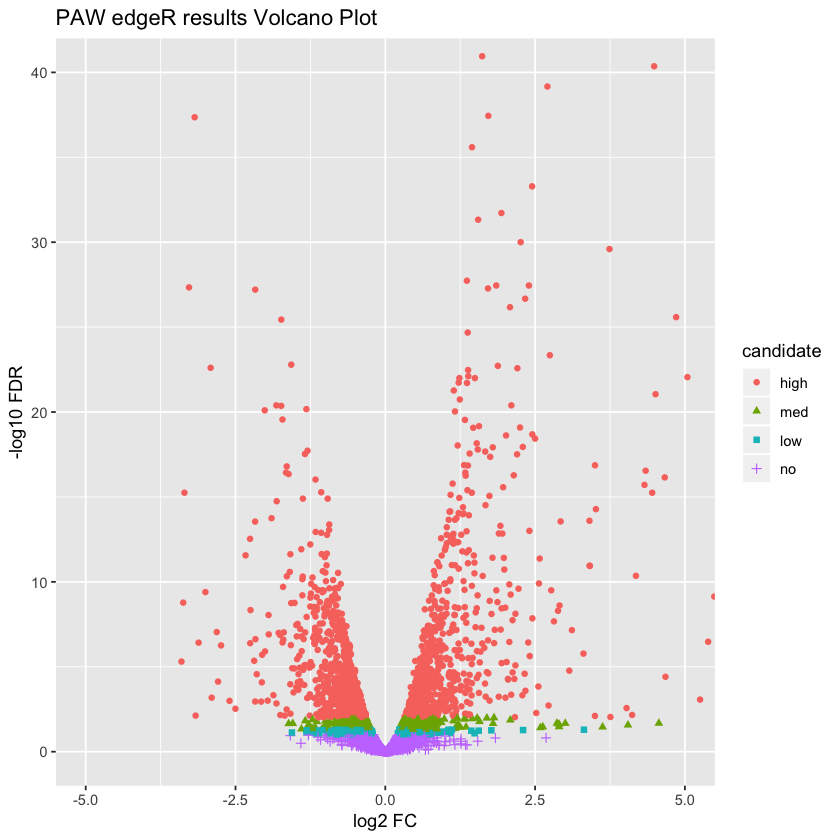

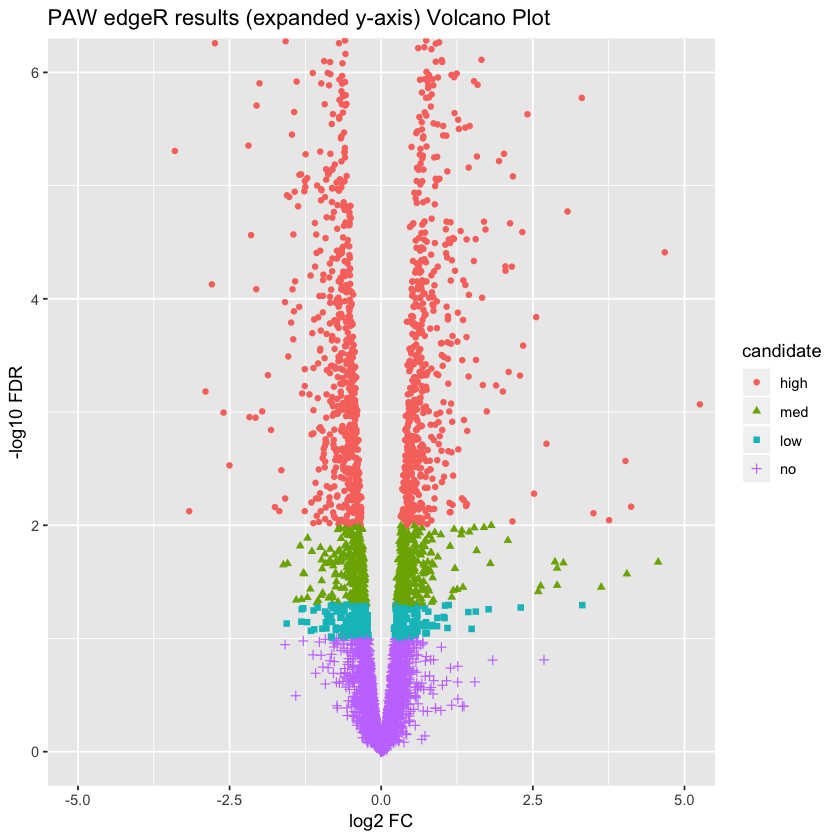

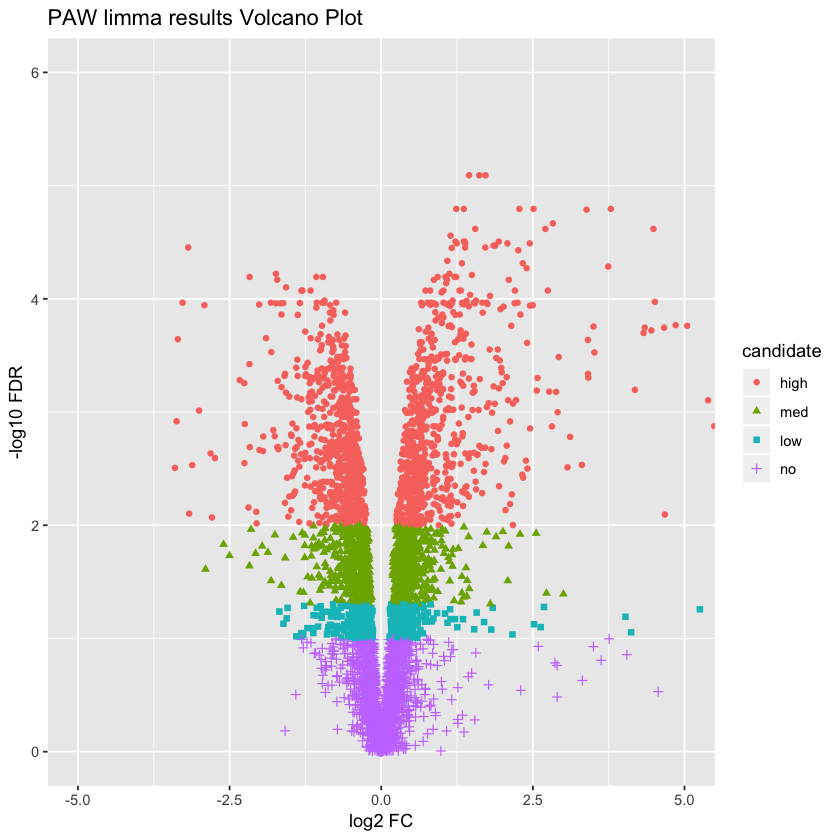

In [76]:
# compare volcano plots
volcano_plot(med_exo, "ave_med", "ave_exo", "PAW edgeR results", 40)
volcano_plot(med_exo, "ave_med", "ave_exo", "PAW edgeR results (expanded y-axis)", 6)
volcano_plot(limma_PAW, "ave_med", "ave_exo", "PAW limma results", 6)

### limma has a little less "V" shape to the volcano plot than edgeR

The range of FDR values returned by the two tests are not the same (easy to see in the volcano plots where the edgeR y-axis goes to 50 (-log10 FDR) in contrast to limma's maximum of 5). The FDR values from limma are more compressed. The center of the "V" is also a little more filled in for limma compared to edgeR. However, the "V" is much better defined for limma than we saw for the t-test. 

## What do the top 10 candidates from limma look like?

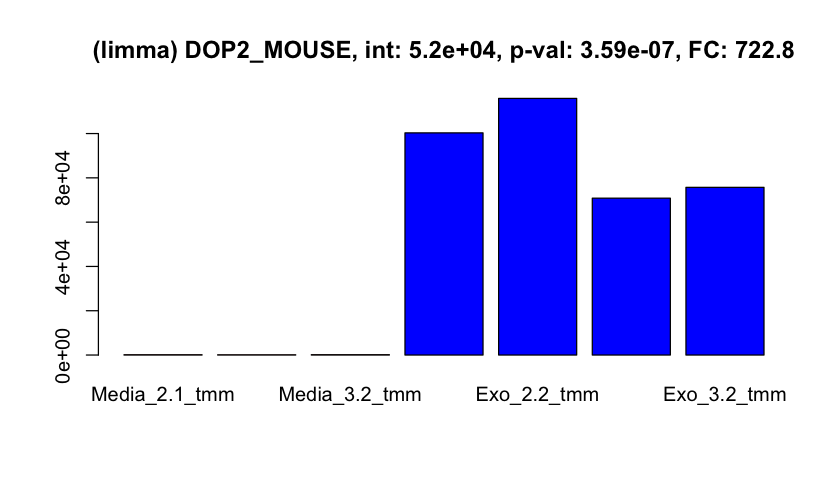

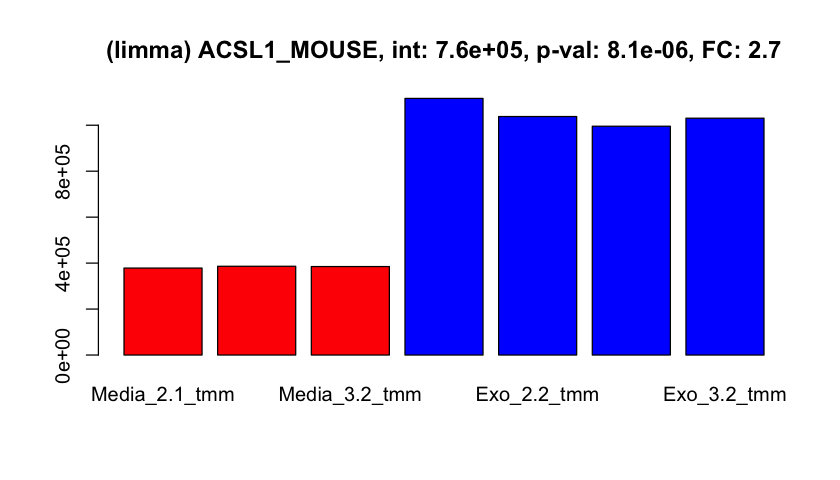

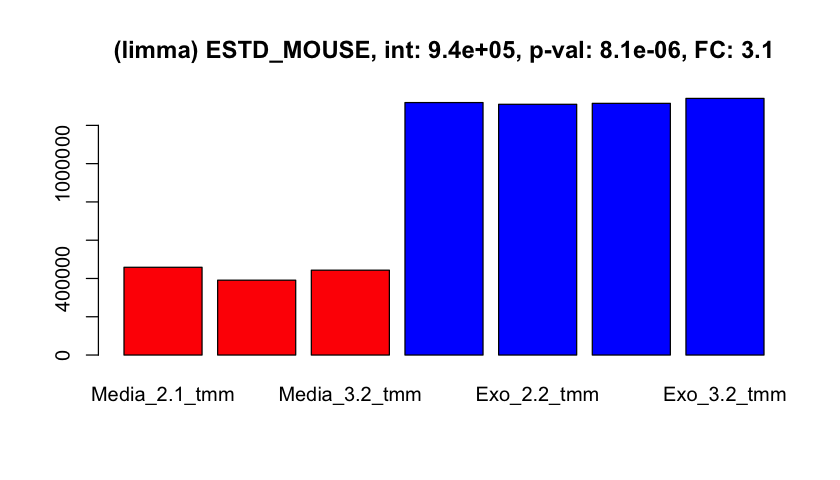

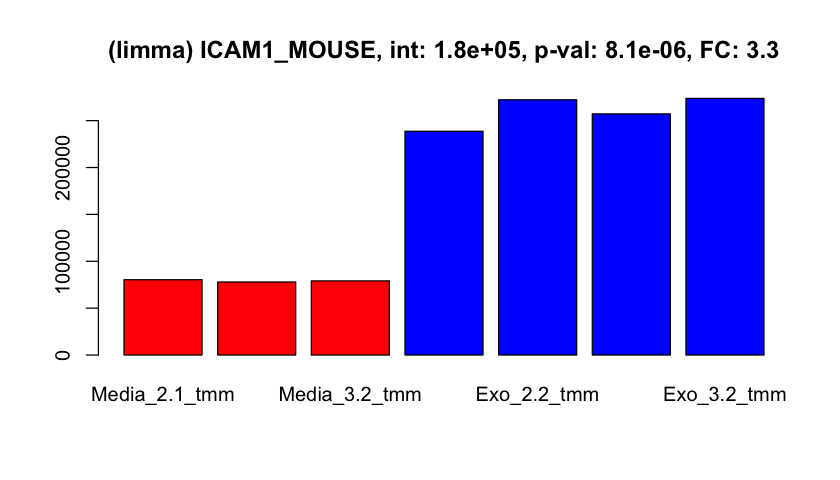

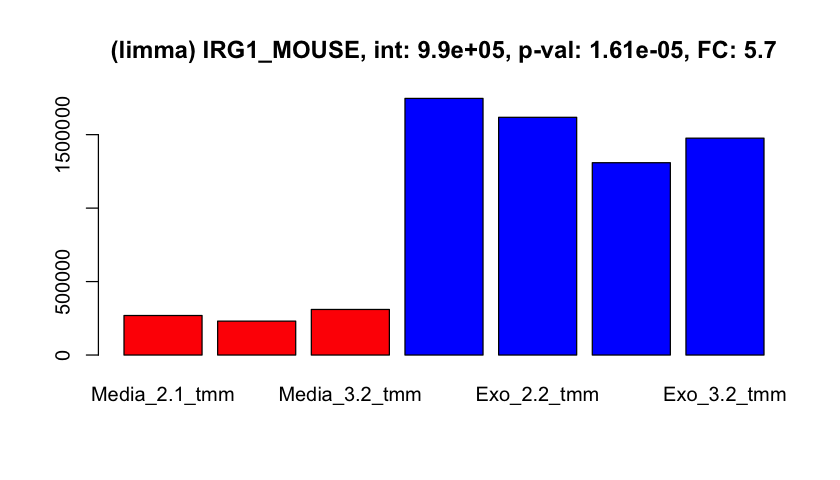

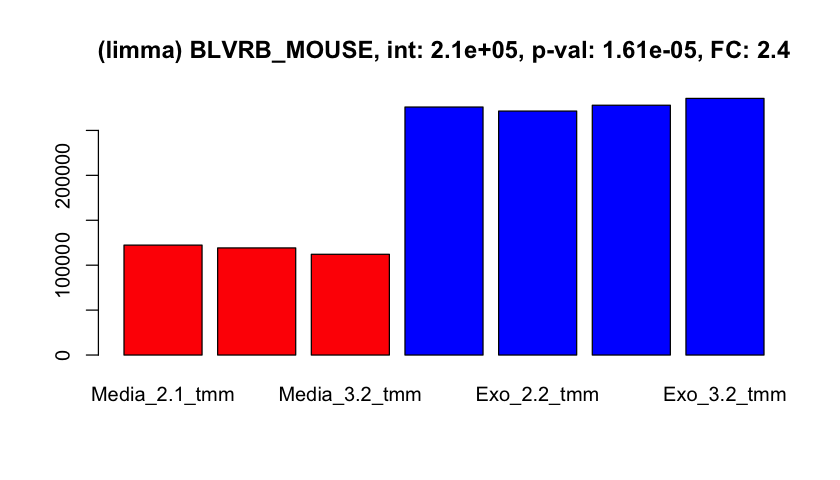

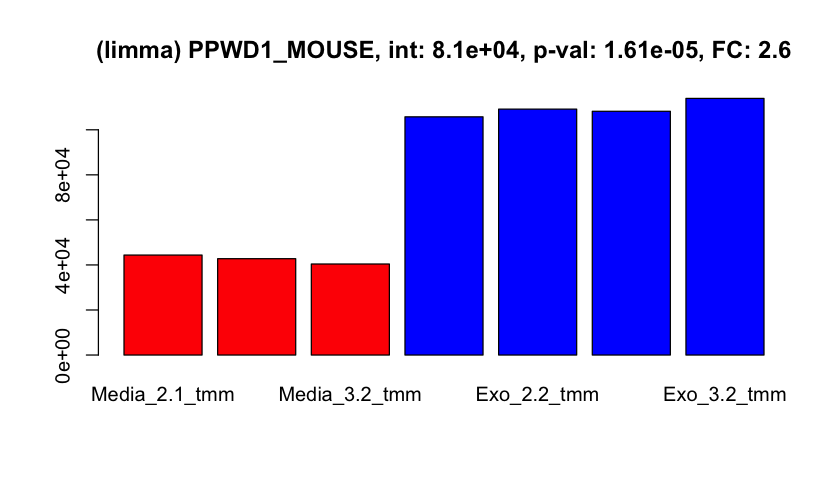

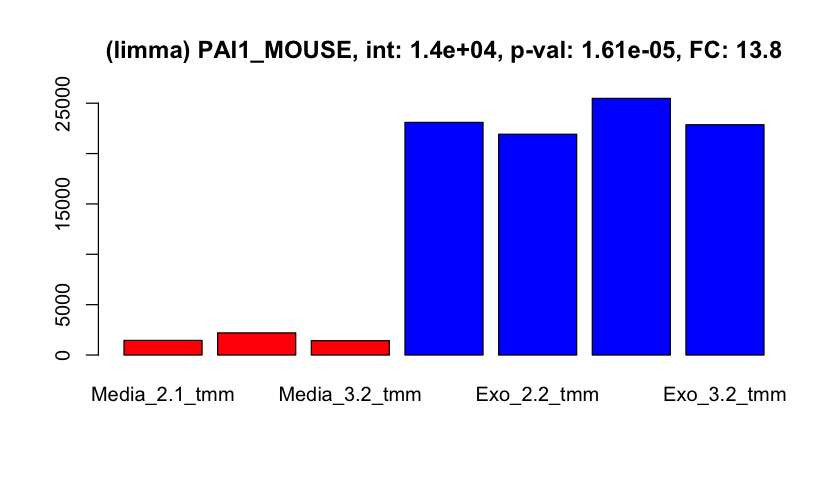

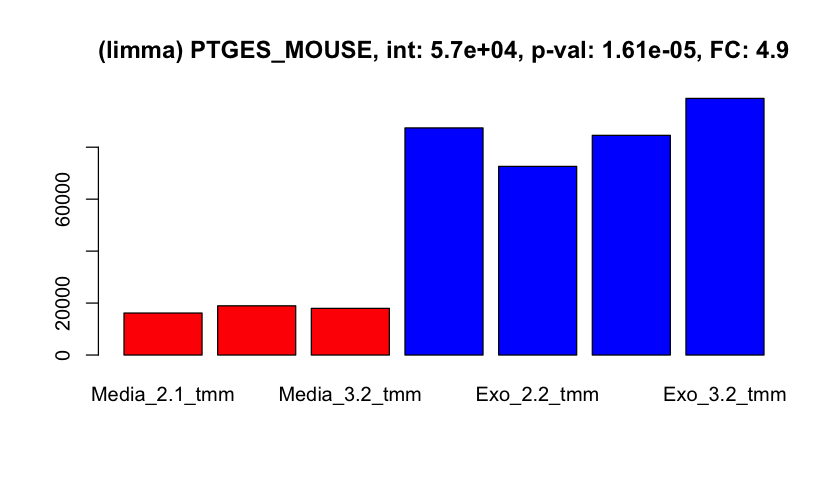

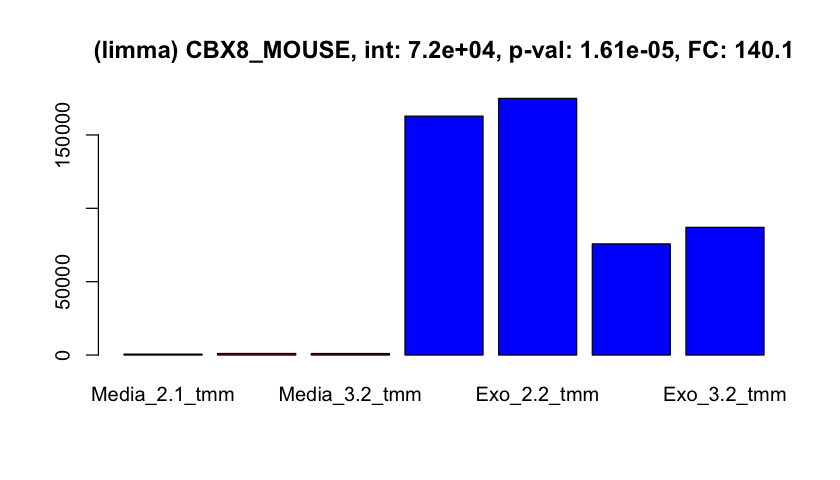

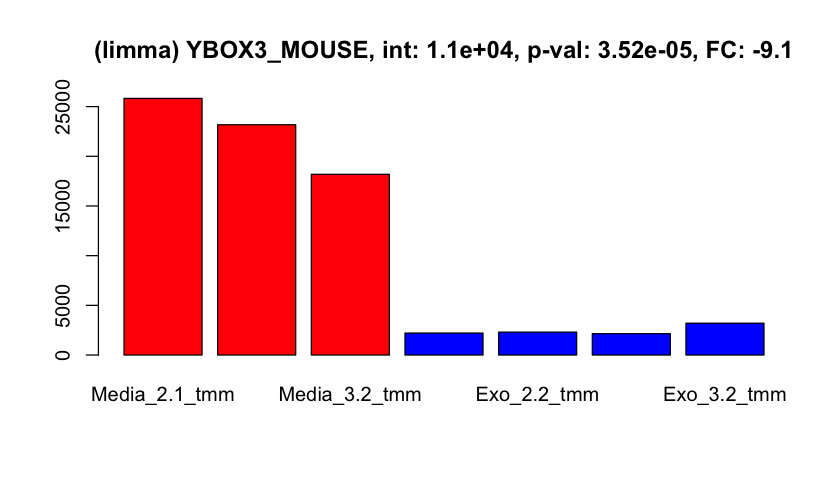

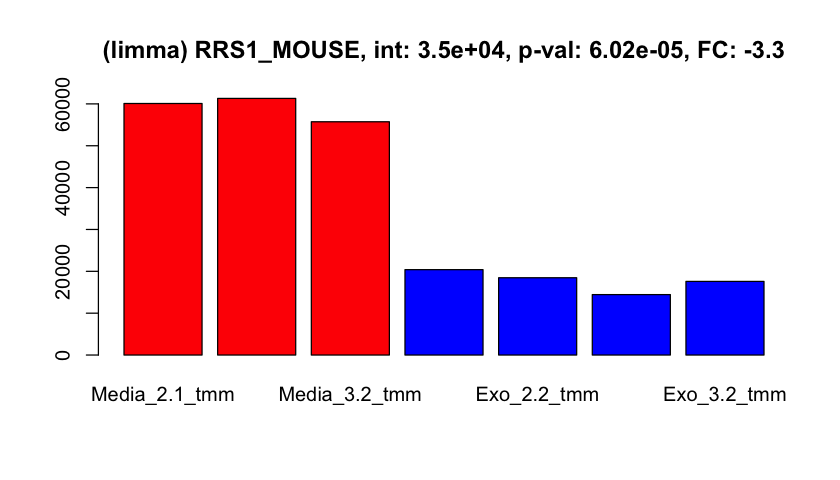

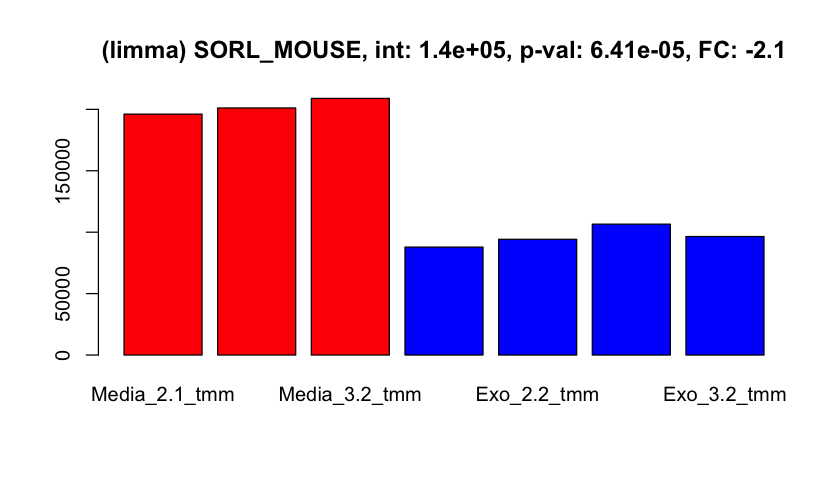

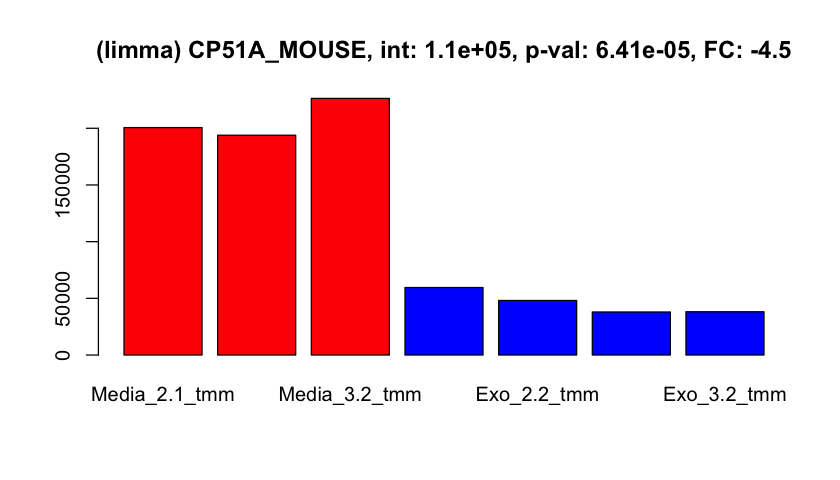

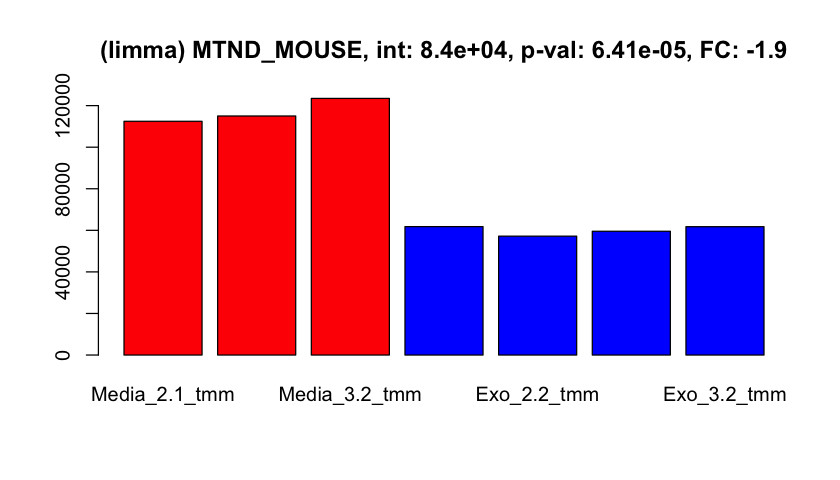

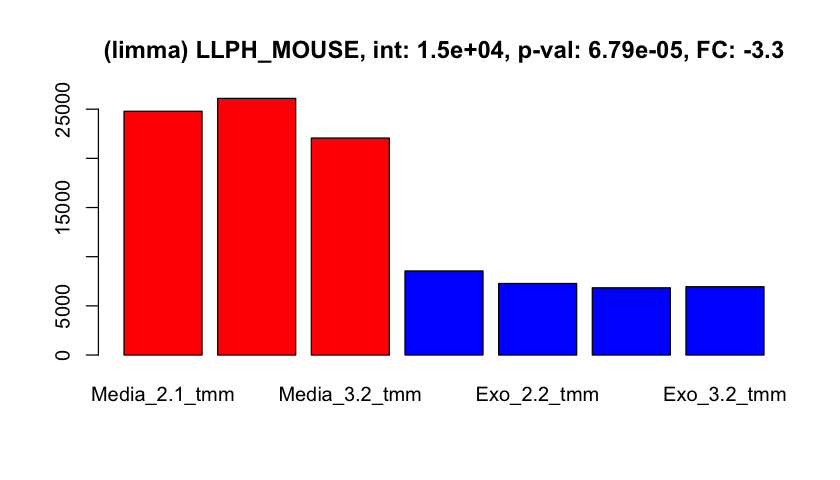

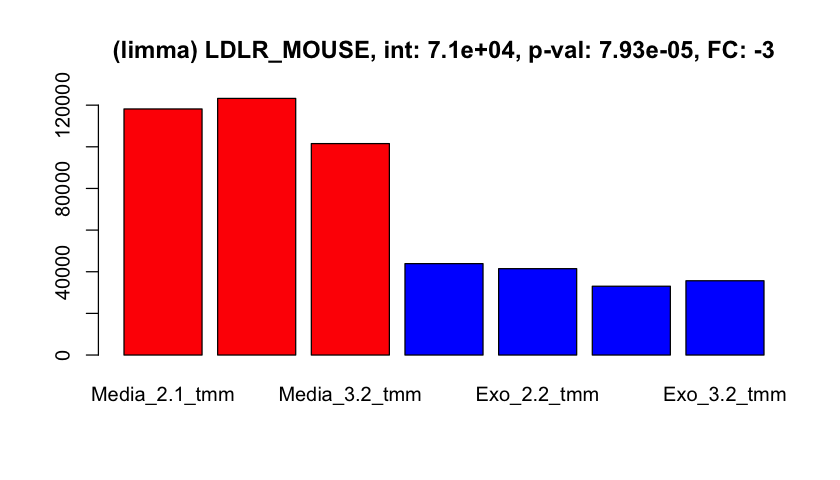

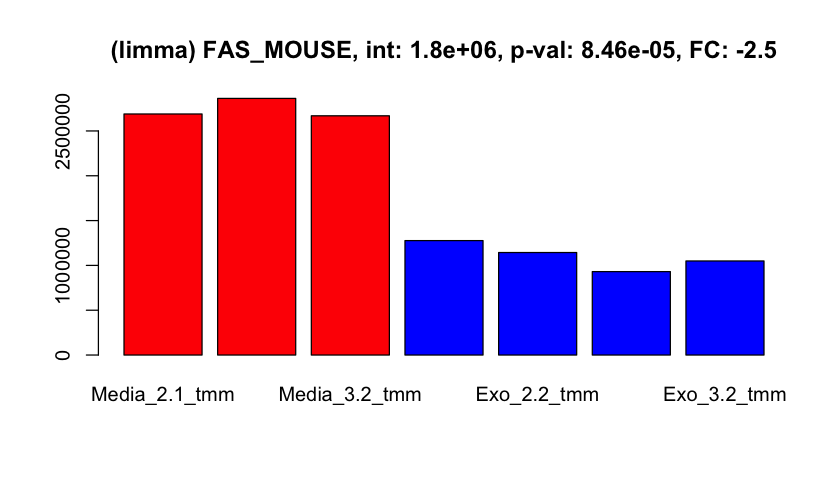

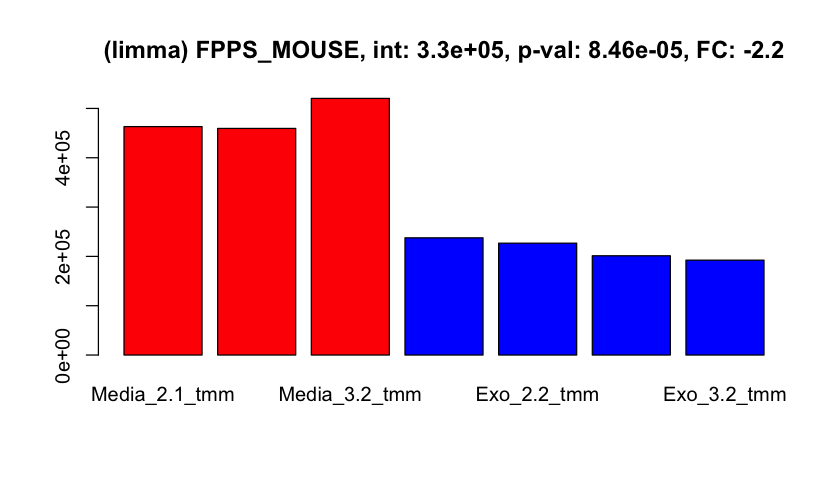

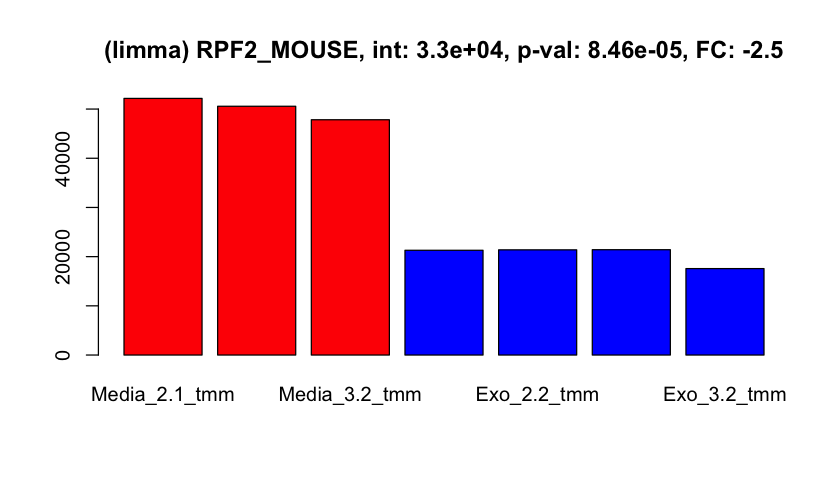

In [77]:
set_plot_dimensions(7, 4)
plot_top_tags(limma_PAW, 3, 4, 10, "(limma) ")
set_plot_dimensions(7, 7)

# How do the edgeR and limma candidates compare to each other?

Comparing two sets of results in omics datasets is far more difficult than most people can imagine. It is a very **fuzzy** endeavor and most ways to compare things do not like fuzzy. We can step through the FDR thresholds and do some set comparisons (intersections, differences, etc.). 

In [78]:
for (cutoff in c(0.10, 0.05, 0.01)) {
    edgeR <- get_identifier(filter(med_exo, FDR < cutoff)$Acc)
    limma <- get_identifier(filter(limma_PAW, FDR < cutoff)$Acc)
    cat("cutoff:", cutoff, "\n")
    cat("number of candidates (edgeR, limma):", length(edgeR), length(limma), "\n")

    x_union <- union(edgeR, limma)
    x_intersect <- intersect(edgeR, limma)
    unique_edgeR <- setdiff(edgeR, limma)
    unique_limma <- setdiff(limma, edgeR)

    cat("union and intersection:", length(x_union), length(x_intersect), "\n")
    cat("intersection out of union:", round(length(x_intersect)/length(x_union), 2), "\n")
    cat("intersection out of edgeR:", round(length(x_intersect)/length(edgeR), 2), "\n")
    cat("intersection out of limma:", round(length(x_intersect)/length(limma), 2), "\n")
    cat("unique to each (edgeR, limma):", length(unique_edgeR), 
        length(unique_limma), "\n\n")
}

edgeR_candidates <- get_identifier(filter(med_exo, FDR < 0.10)$Acc)
limma_candidates <- get_identifier(filter(limma_PAW, FDR < 0.10)$Acc)
unique_edgeR_candidates <- setdiff(edgeR_candidates, limma_candidates)
unique_limma_candidates <- setdiff(limma_candidates, edgeR_candidates)

cat("Candidates in limma but not candidate (<0.1) in edgeR")
interesting_limma <- setdiff(unique_limma_candidates, edgeR_candidates)
length(interesting_limma)
cat("Candidates in edgeR but not candidate (<0.1) in limma")
interesting_edgeR <- setdiff(unique_edgeR_candidates, limma_candidates)
length(interesting_edgeR)

cutoff: 0.1 
number of candidates (edgeR, limma): 2489 2829 
union and intersection: 2877 2441 
intersection out of union: 0.85 
intersection out of edgeR: 0.98 
intersection out of limma: 0.86 
unique to each (edgeR, limma): 48 388 

cutoff: 0.05 
number of candidates (edgeR, limma): 2114 2327 
union and intersection: 2396 2045 
intersection out of union: 0.85 
intersection out of edgeR: 0.97 
intersection out of limma: 0.88 
unique to each (edgeR, limma): 69 282 

cutoff: 0.01 
number of candidates (edgeR, limma): 1580 1446 
union and intersection: 1654 1372 
intersection out of union: 0.83 
intersection out of edgeR: 0.87 
intersection out of limma: 0.95 
unique to each (edgeR, limma): 208 74 

Candidates in limma but not candidate (<0.1) in edgeR

[1] 388

Candidates in edgeR but not candidate (<0.1) in limma

[1] 48

### Significant results from edgeR are essentially contained within limma significant results

We had 388 more DE candidates with limma compared to edgeR. There were only 48 proteins (out of almost 5000) that were significant in edgeR but not also significant in limma. Given the magnitude of the intenstiy values, modeling expression with a negative binomial distribution or a normal distributions seems pretty similar in terms of test outcomes. Considering the compicated nature of the statistical testing, the agreement is rather remarkable. 

In [79]:
# these are high in limma but not high in edgeR (74)
interesting <- setdiff(unique_limma, edgeR_candidates) # high in limma but not a candidate in edgeR
not_interesting <- setdiff(unique_limma, interesting) # high in limma and also a candidate in edgeR
cat(length(interesting), length(not_interesting))

0 74

In [80]:
plot_selected <- function(results, nleft, nright, selected, prefix) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # selected is list of identifiers to plot
    proteins <- results
    proteins$ident <- get_identifier(results$Acc)
    proteins <- filter(proteins, ident %in% selected)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(prefix, row$ident, ", int: ", scientific(mean(vec), 2), 
                       ", p-val: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1))
        barplot(vec, col = color, main = title)
    }    
}

#set_plot_dimensions(7, 4)
#plot_selected(limma_PAW, 3, 4, sample(not_interesting, 10), "(limma) ")
#set_plot_dimensions(7, 7)

### There were zero proteins highly significant in limma that were not candidates in edgeR

In [81]:
# plot the t-test candidates that were not significant in edgeR
#set_plot_dimensions(7, 4)
#plot_selected(limma_PAW, 3, 4, interesting, "(limma) ")
#set_plot_dimensions(7, 7)

## Can we use facet plots to shed some light on the comparison?

ggplot (and visualization in general) has several ways to explore dimensionality. Different point shapes and colors can be used in the same plots. Plots can also be separated by categories and aligned to facilitate comparisons. We can do both techniques. We can color code by the candidate status in one test and facet plot by the candidate status in the other test. We might gain some useful insight, or be hopelessly confused.

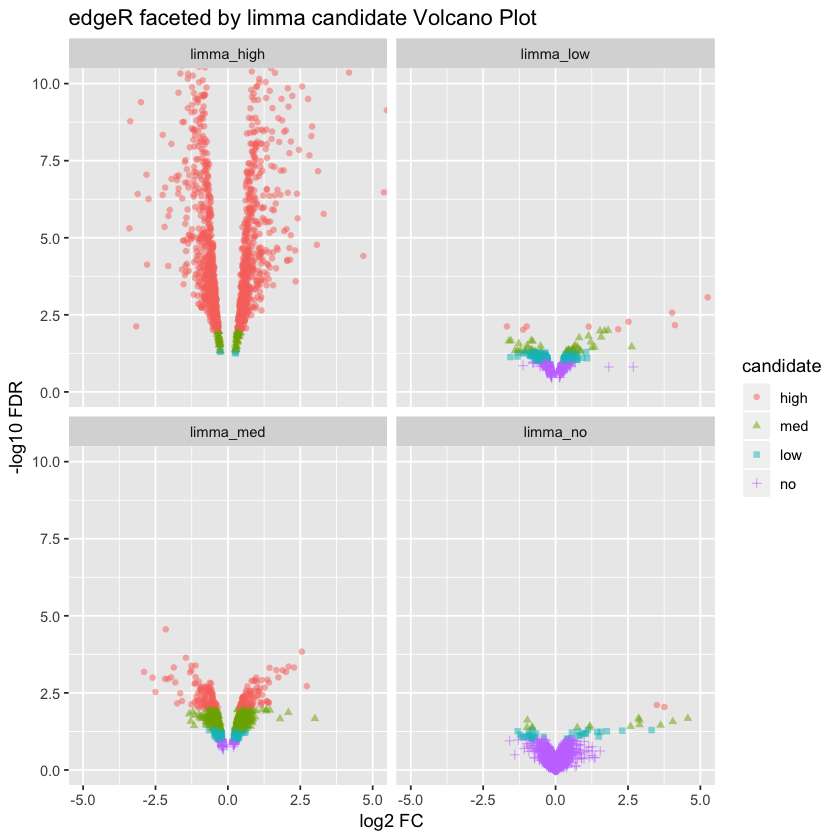

In [82]:
set_plot_dimensions(7, 7)
volcano_plot_facet <- function(results, x, y, other, title, ymax) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # ymax - upper limit for y-axis
        # title - plot title string
        # other - candidate flags from the other test
    
    # uses transformed data
    temp <- transform(results, x, y)
    temp$other <- other
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate), alpha = 0.5) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        coord_cartesian(xlim = c(-5, 5), ylim = c(0, ymax)) + 
        facet_wrap(~ other) +
        ggtitle(str_c(title, " Volcano Plot"))
}

# cross-candidate faceted volcano plots
volcano_plot_facet(med_exo, "ave_med", "ave_exo", str_c("limma_", limma_PAW$candidate), 
                   "edgeR faceted by limma candidate", 10)

### Some larger fold-change proteins are significant in edgeR

Most non-candidate proteins are the same from both tests. There are a lot of purple points in the lower right panel. EdgeR has few candidates that were not candidates from limma, and they tend to have larger fold-changes. That trend is also present in the upper right panel for the low candidates in limma. The agreement between more significant candidates from limma and the more significant candidates from edgeR looks pretty good.

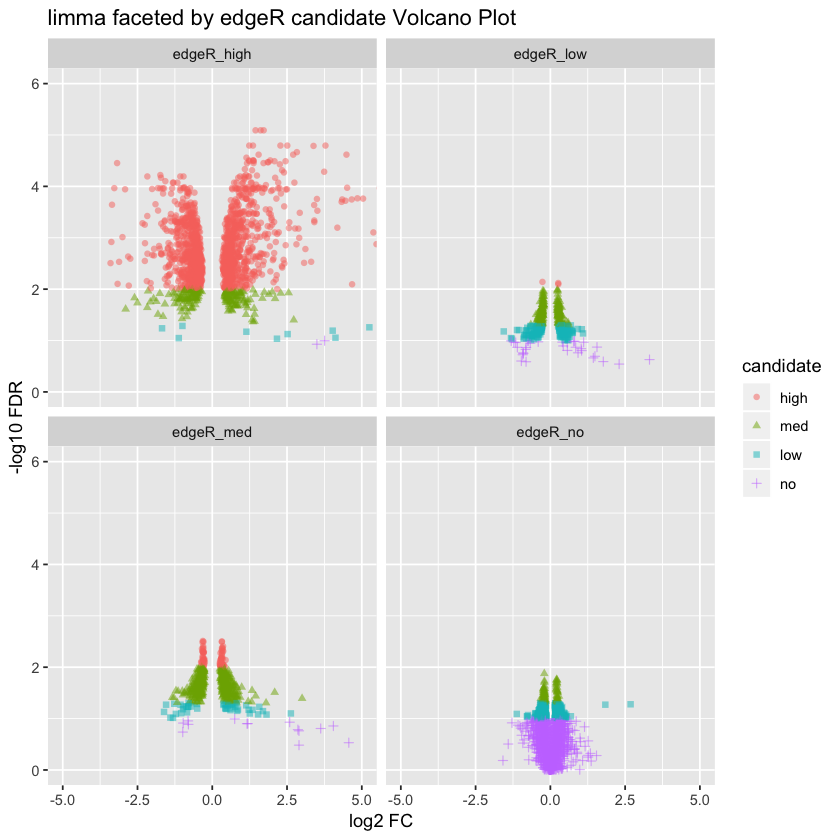

In [83]:
# with the tests switched
volcano_plot_facet(limma_PAW, "ave_med", "ave_exo", str_c("edgeR_", med_exo$candidate), 
                   "limma faceted by edgeR candidate", 6)

### There are some smaller fold-change proteins that are significant in limma

We have effects similar to the t-test results where some smaller fold-change proteins achieve significance in limma that did not in edgeR. Those are the low and medium color points (from limma) in the lower right panel. There were 388 more DE candidates from limma compared to edgeR. The points in the edgeR_low and edgeR_med plots are mostly coming from some DE category shuffling. There are not many purple points in either panel.

The comments after the plot of the biological coefficient of variance are seen in the comparisons. The trended variance blue line lies above the individual protein variances in most cases. The means that there will have to be a bit more of a difference in means before edgeR will return small p-values. That effectively eliminates small fold change proteins without having to invoke an *ad hoc* cutoff. Conversely, large fold changes can overcome high variance when using moderated testing.

There are so many factors that can affect testing p-values: the data itself, normalizations and transformations, the test and test parameter choices, the underlying distribution assumption (if parametric), how trended variances are computed in moderated tests, choice of multiple testing correction method, and probably many more factors. We need better ways to explore, evaluate, and compare the choices.

# Take home: edgeR results are mostly a subset of limma results

- limma had more overall DE candidates (388) than edgeR
- nearly all edgeR candidates were contained within the limma candidates
  - only 48 proteins were not
- some of the extra limma candidates do have smaller fold changes, however

The negative binomial modeling in edgeR is mostly benign when we work with reporter ion peak heights. The numbers are large. EdgeR would likely be less appropriate if the scale of the numbers were smaller. The non-sensical signal-to-noise ratios that are used by default in Proteome Discoverer 2.x are a case in point.

There are some features in [limma](https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf) that are not in [edgeR](https://www.bioconductor.org/packages/devel/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf). One was `TREAT`, a way to incorporate a fold-change threshold cutoff into the statistical model (reference below). This is now also available in edgeR if you use the general linear model framework instead of the simpler exact test. This feature can be very useful when the numbers of DE candidates becomes large. It is a way to home in on the key driver genes. Follow up experiments are expensive and have to be prioritized. 

Interpretation of DE candidates to form actionable hypotheses is a tough challenge. This is a real cart and horse situation. It is very hard to interpret results in a vacuum. Intimate and deep biological knowledge of the system under study is needed. The people with those brains are typically not well equipped to wrangle large data sets. The folks that love to wrangle large data sets and model things you never thought needed modeling can be rendered a lot less effective without deep domain knowledge. Enrichment analyses are one class of techniques that try to get knowledge from the data without actually knowing anything about the data (sounds kind of weird, right?). Nevertheless, new tools test sets of genes for enrichment rather than individual genes. This makes much more sense scientifically because most biological processes involve multiple genes/proteins. limma has options for gene set enrichment testing. I have not had time to learn about them yet. When I do, I will add a new repository and share what I learn.

> McCarthy, D.J. and Smyth, G.K., 2009. Testing significance relative to a fold-change threshold is a TREAT. Bioinformatics, 25(6), pp.765-771. 

## Log the session information

One step towards more meaningful results summaries are getting the main proteomics results and the statistical results combined into a single table. If we are careful with how we bring the data into R and how we take it back out, we can keep tables in order so merging results are easier. We kept the accessions column as we worked with the data. We can be really robust and use merge functions to weave together starting tables with final results tables. 

We should always end notebooks with information about what packages and versions were used in the analysis.

In [84]:
# save the testing results
#write.table(med_exo, file = "KUR1502_results_limma.txt", sep = "\t",
#            row.names = FALSE, na = " ")

# log the session
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.4

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] edgeR_3.24.3    limma_3.38.3    scales_1.0.0    gridExtra_2.3  
 [5] psych_1.8.12    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1  
 [9] purrr_0.3.2     readr_1.3.1     tidyr_0.8.3     tibble_2.1.1   
[13] ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     locfit_1.5-9.1   tidyselect_0.2.5 repr_0.19.2     
 [5] splines_3.5.3    haven_2.1.0      lattice_0.20-38  colorspace_1.4-1
 [9] generics_0.0.2   htmltools_0.3.6  base64enc_0.1-3  rlang_0.